# Wstęp

Celem projektu jest wytrenowanie wariantów modeli: klasycznej sieci splotowej (CNN) oraz sieci resztkowej (ResNet), a następne ich porównanie. Porównanie będzie się opierać na treningu na bazie zbioru danych EMNIST. 

# Przygotowanie

## Import bibliotek

In [2]:
import pandas as pd
import numpy as np
import math
import string
import matplotlib.pyplot as plt
import seaborn as sns

import torch
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
import torch.nn as nn
import torch.optim as optim
from torch.amp import GradScaler, autocast
from torch.optim.lr_scheduler import ReduceLROnPlateau, StepLR
from torch.utils.data import random_split

from tqdm.notebook import tqdm
import os
from pathlib import Path
import zipfile
import random
import kagglehub

from sklearn.cluster import KMeans
from scipy.spatial.distance import cdist
from sklearn.metrics import silhouette_score, pairwise_distances
from sklearn.decomposition import PCA
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

from models import SimpleCNN, SimpleCNNDeep, SimpleCNNWide, ResNet, ResidualBlock, EMNISTDataset

## Import danych

Wykorzystamy zbiór EMNIST balanced (131600 znaków, 47 unikalnych klas) przekonwertowany i podzielony już na pliki formatu .csv </br>
Poniższy kod pobiera dane treningowe, testowe i mapujące z kaggle (https://www.kaggle.com/datasets/crawford/emnist).

In [99]:
# Pobieramy dane prosto z Kaggle
path = kagglehub.dataset_download("crawford/emnist")
print("Ścieżka do zbioru danych:", path)

Ścieżka do zbioru danych: C:\Users\matik\.cache\kagglehub\datasets\crawford\emnist\versions\3


Baza EMNIST balanced, pobrana w plikach, jest już podzielona: 112800 elementów w danych treningowych (86%) oraz 18800 w testowych (14%). Na etapie uczenia modelu, dane treningowe zostaną dodatkowo podzielone na dane treningowe i walidacyjne w proporcji 80/20.

In [100]:
train = pd.read_csv(f'{path}/emnist-balanced-train.csv', header=None)
test = pd.read_csv(f'{path}/emnist-balanced-test.csv', header=None)

train.shape, test.shape

((112800, 785), (18800, 785))

In [5]:
train.head()

,0,1,2,3,4,5,6,7,8,9,...,775,776,777,778,779,780,781,782,783,784
0,45,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,36,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,43,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,15,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,4,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [6]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 112800 entries, 0 to 112799
Columns: 785 entries, 0 to 784
dtypes: int64(785)
memory usage: 675.6 MB


In [7]:
train.describe()

,0,1,2,3,4,5,6,7,8,9,...,775,776,777,778,779,780,781,782,783,784
count,112800.00000,112800.0,112800.0,112800.0,112800.0,112800.000000,112800.000000,112800.000000,112800.000000,112800.000000,...,112800.000000,112800.0,112800.0,112800.000000,112800.000000,112800.0,112800.0,112800.0,112800.0,112800.0
mean,23.00000,0.0,0.0,0.0,0.0,0.001365,0.011560,0.020700,0.017438,0.018475,...,0.000310,0.0,0.0,0.002163,0.000284,0.0,0.0,0.0,0.0,0.0
std,13.56472,0.0,0.0,0.0,0.0,0.235046,1.221826,1.658797,1.602478,1.719549,...,0.104211,0.0,0.0,0.726499,0.095279,0.0,0.0,0.0,0.0,0.0
min,0.00000,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0
25%,11.00000,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0
50%,23.00000,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0
75%,35.00000,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0
max,46.00000,0.0,0.0,0.0,0.0,63.000000,192.000000,217.000000,217.000000,217.000000,...,35.000000,0.0,0.0,244.000000,32.000000,0.0,0.0,0.0,0.0,0.0


# Analiza zbioru danych

Nie ma brakujących wartości w obu zbiorach.

In [8]:
nan_values = train.isna().sum().sum() + test.isna().sum().sum()
print(f"Liczba brakujących wartości: {nan_values}")

Liczba brakujących wartości: 0


Plik z danymi treningowymi zawiera 112800 wierszy i 785 kolumn. Pierwsza kolumna to etykieta (numer od 0 do 46), a pozostałe 784 kolumny przedstawiają piksele obrazu 28x28. Taki sam układ występuje w pliku z danymi testowymi. Etykiety odpowiadają cyfrom oraz dużym i małym literom alfabetu angielskiego. Mapowanie indeksów klas na etykiety znajduje się w pliku emnist-balanced-mapping.txt.

In [101]:
mapping = pd.read_csv(f'{path}/emnist-balanced-mapping.txt', delimiter=' ', header=None)
mapping_dict = {mapping.iloc[i, 0]: chr(mapping.iloc[i, 1]) for i in range(len(mapping))}

print(f"Mapping size: {len(mapping)}")
print(dict(list(mapping_dict.items())))

Mapping size: 47
{0: '0', 1: '1', 2: '2', 3: '3', 4: '4', 5: '5', 6: '6', 7: '7', 8: '8', 9: '9', 10: 'A', 11: 'B', 12: 'C', 13: 'D', 14: 'E', 15: 'F', 16: 'G', 17: 'H', 18: 'I', 19: 'J', 20: 'K', 21: 'L', 22: 'M', 23: 'N', 24: 'O', 25: 'P', 26: 'Q', 27: 'R', 28: 'S', 29: 'T', 30: 'U', 31: 'V', 32: 'W', 33: 'X', 34: 'Y', 35: 'Z', 36: 'a', 37: 'b', 38: 'd', 39: 'e', 40: 'f', 41: 'g', 42: 'h', 43: 'n', 44: 'q', 45: 'r', 46: 't'}


Pełny zbiór EMNIST zawiera 62 klasy (26 małych i dużych liter alfabetu łacińskiego oraz 10 cyfr). My jednak wykorzystujemy wariant "zbalansowany" – zrównoważony zbiór wariantu scalonego ([szerszy opis](https://arxiv.org/pdf/1702.05373v1)), który ze względu na podobieństwo niektórych liter w dużej i małej formie (np. C i c) scala 15 liter: C, I, J, K, L, M, O, P, S, U, V, W, X, Y, Z, zmniejszając liczbę klas do 47 (62 - 15 = 47).

In [82]:
mapping_lowercase_letters = [val for val in mapping_dict.values() if val.isalpha() and val.islower()]
mapping_merged_letters = [val for val in mapping_dict.values() if val.isalpha() and val.isupper() and (val.lower() not in mapping_lowercase_letters)]

print(f"Liczba liter wspólnych (scalonych): {len(mapping_merged_letters)}")
print(f"Litery wspólne: {mapping_merged_letters}")

Liczba liter wspólnych (scalonych): 15
Litery wspólne: ['C', 'I', 'J', 'K', 'L', 'M', 'O', 'P', 'S', 'U', 'V', 'W', 'X', 'Y', 'Z']


Dystrybucja etykiet (klas) w danych treningowych i testowych jest zrównoważona - każda etykieta dokładnie występuje tyle samo razy. Dla danych treningowych: 47\*2400=112800, a testowych: 47\*400=18800. Gotowy podział zbioru na dane testowe i treningowe jest bardzo dobry.

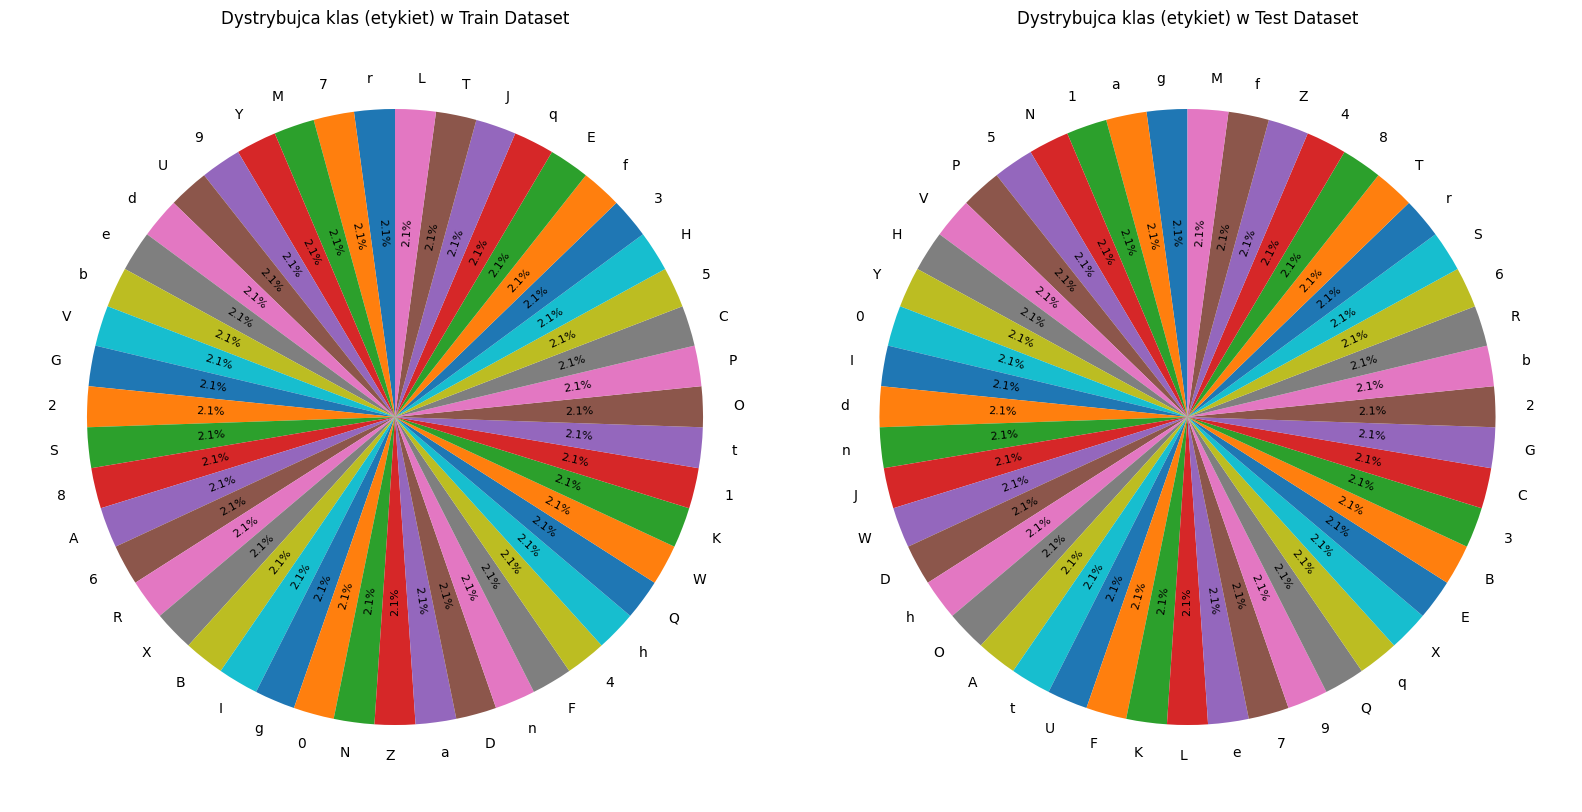

In [11]:
fig, axes = plt.subplots(1, 2, figsize=(16, 8))

for ax, (dataset_name, t_) in zip(axes, [("Train", train[0].value_counts()), ("Test", test[0].value_counts())]):
    t__classes_x = [mapping_dict.get(label, label) for label in t_.index]
    t__classes_y = t_.values

    wedges, texts, autotexts = ax.pie(
        t__classes_y,
        labels=t__classes_x,
        autopct='%1.1f%%',
        startangle=90,
        colors=plt.cm.tab10.colors[:len(t__classes_x)]
    )

    for autotext in autotexts:
        autotext.set_fontsize(8)
        x, y = autotext.get_position()
        angle = math.degrees(math.atan2(y, x))
        if x <= 0:
            angle += 180
        autotext.set_rotation(angle)

    ax.set_title(f'Dystrybujca klas (etykiet) w {dataset_name} Dataset', fontsize=12)

plt.tight_layout()
plt.show()

## Formatowanie danych

Teraz wyświetlimy przykładowe dane ze zbioru treningowego.

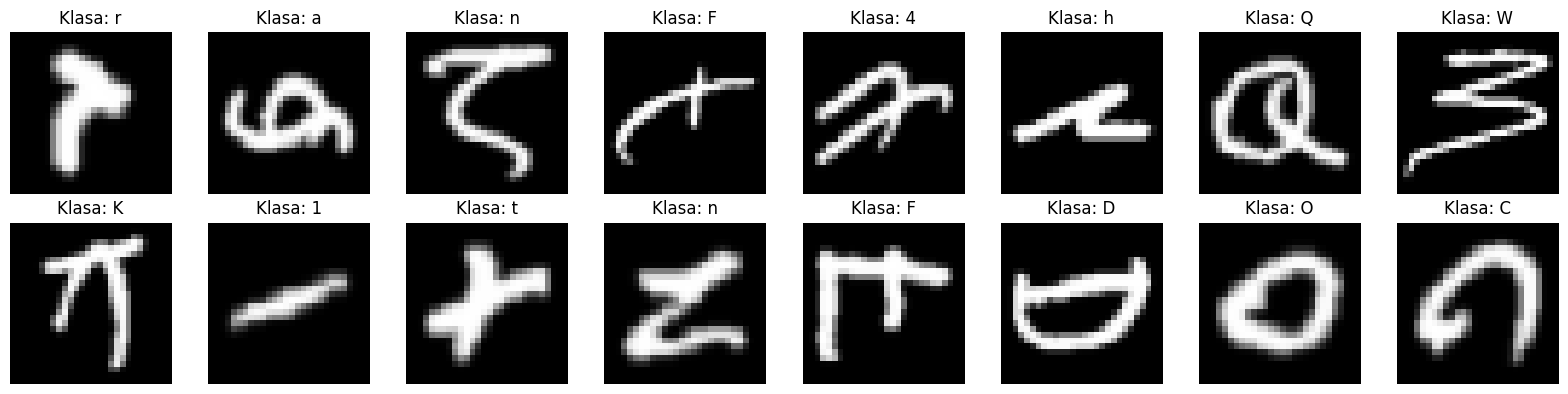

In [102]:
fig, axes = plt.subplots(2, 8, figsize=(16, 4))

for i, ax in enumerate(axes.flat):
    example = train.iloc[i, ]
    label = mapping_dict[example.iloc[0]]
    
    example = example[1:].values.reshape(28, 28)
    
    ax.imshow(example, cmap='gray')
    ax.set_title(f'Klasa: {label}')
    ax.axis('off')

plt.tight_layout()
plt.show()

Dane w zbiorze EMNIST są domyślnie odwrócone, więc należy je obrócić wokół przekątnej.

In [103]:
for t in train, test:
    for i in range(t.shape[0]):
        pixels = t.iloc[i,1:]
        image = pixels.values.reshape(28,28, 1).T
        pixels = image.flatten()
        t.iloc[i,1:] = pixels

I jeszcze raz wyświetlimy (w poprawnym już formacie) dane.

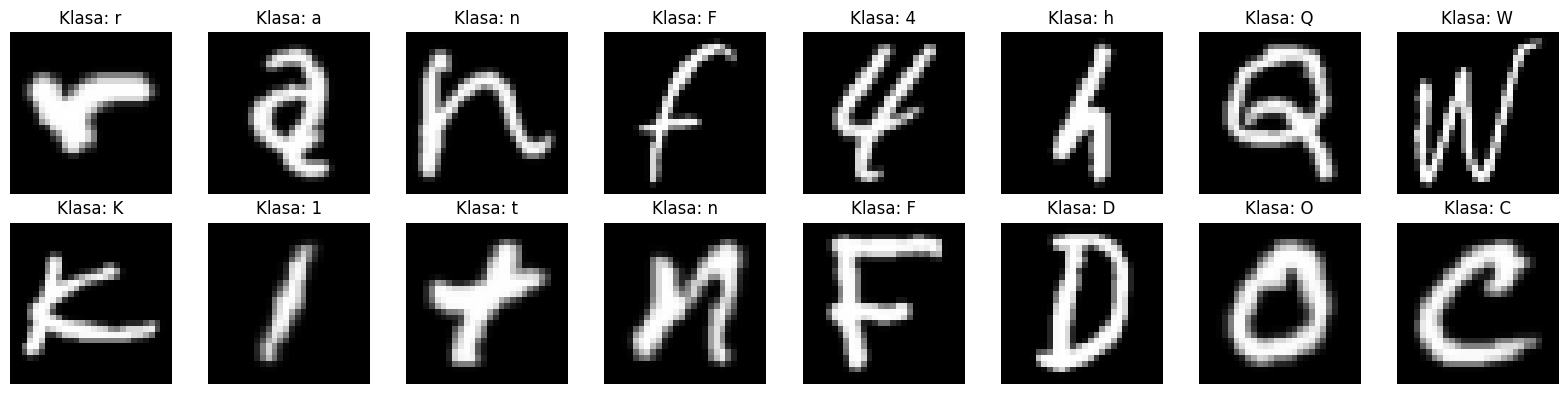

In [104]:
fig, axes = plt.subplots(2, 8, figsize=(16, 4))

for i, ax in enumerate(axes.flat):
    example = train.iloc[i, ]
    label = mapping_dict[example.iloc[0]]
    
    example = example[1:].values.reshape(28, 28)
    
    ax.imshow(example, cmap='gray')
    ax.set_title(f'Klasa: {label}')
    ax.axis('off')

plt.tight_layout()
plt.show()

## Porównanie klas

Utworzymy teraz mapy ciepła pikseli dla każdej klasy z osobna. Każda mapa reprezentuje średni obraz danej klasy, w którym każdy piksel jest średnią arytmetyczną wartości pikseli z odpowiadających mu pozycji we wszystkich obrazach tej klasy. Nad każdym takim obrazem umieścimy liczbę reprezentującą średnią intensywność wszystkich pikseli tego przeciętnego obrazu.

C:\Users\matik\AppData\Local\Temp\ipykernel_29424\1630798353.py:34: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout(rect=[0, 0.15, 1, 0.97])


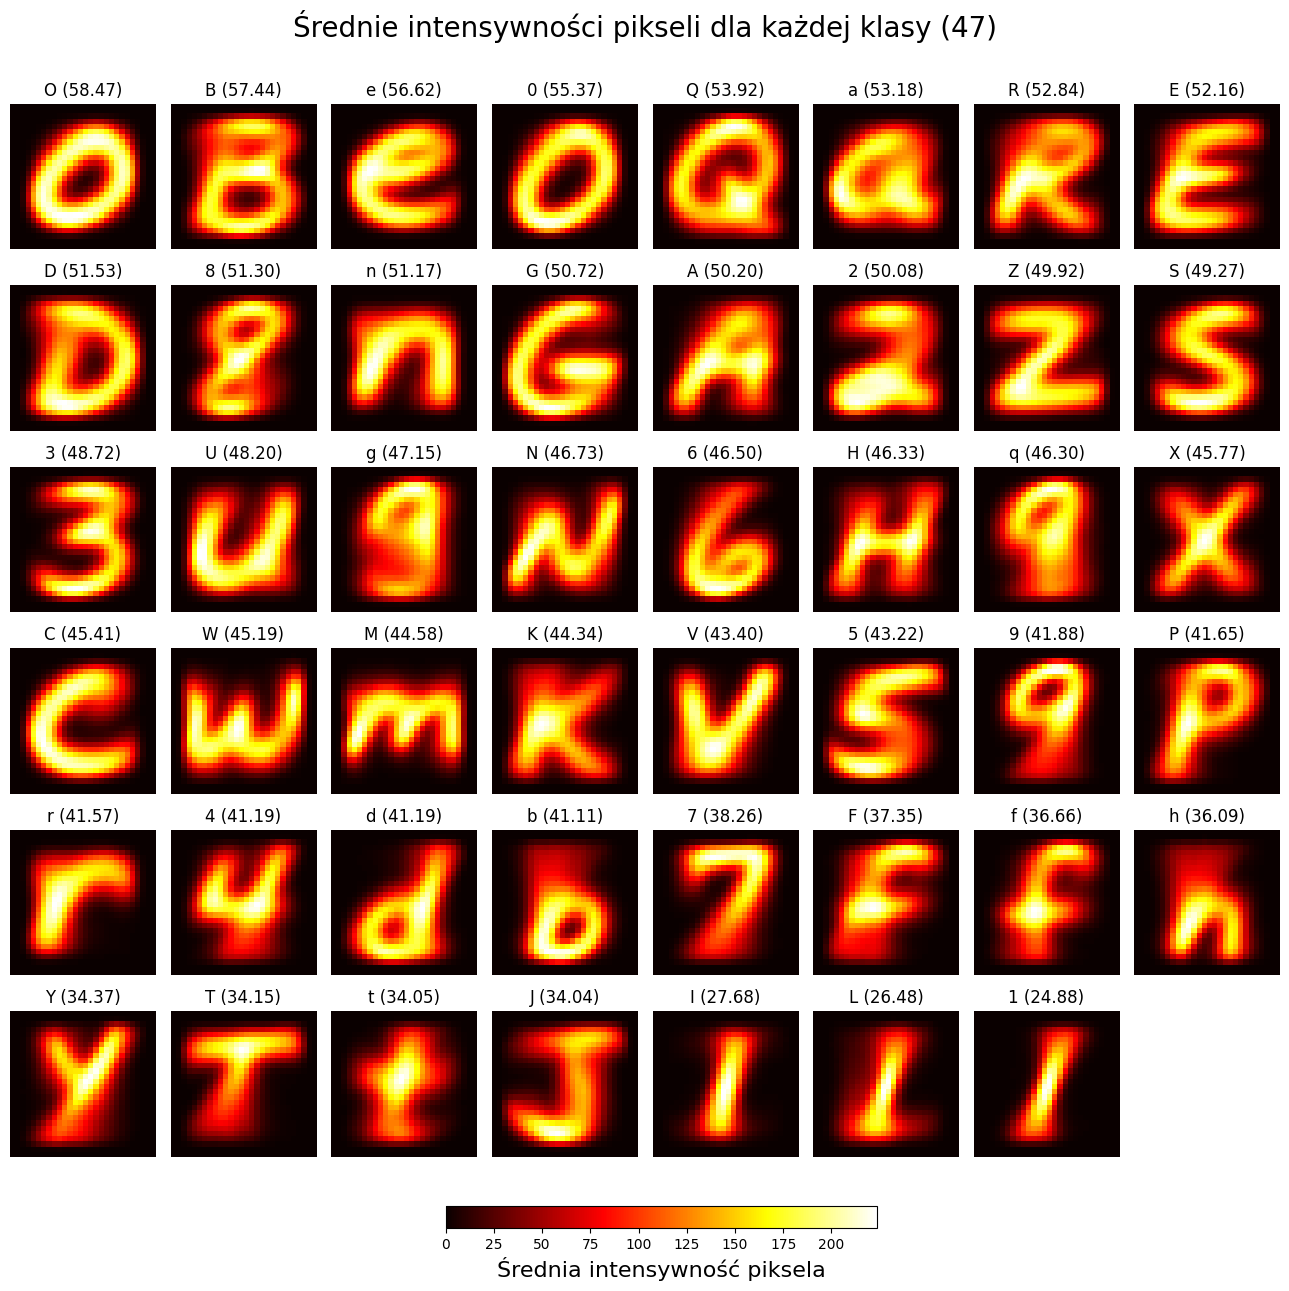

In [15]:
average_images = {}
average_images_means = {}

for label in mapping_dict.keys():
    # bierzemy wszystkie obrazy z danej klasy (label)
    images = train[train.iloc[:, 0] == label].iloc[:, 1:].values

    average_image = np.mean(images.reshape(images.shape[0], 28, 28), axis=0)
    image_mean = np.mean(average_image)
    
    # zapisujemy wyliczony przeciętny obraz oraz przeciętną wartość jego pikseli
    average_images[label] = average_image
    average_images_means[label] = image_mean

fig, axes = plt.subplots(6, 8, figsize=(13, 14))  # 6 x 8 (48, 1 pole puste)
axes = axes.flatten()

# wyświetlamy mapy ciepła posortowane wg wartości przeciętnej wartości pikseli w kolejności od najwyższej do najniższej
for idx, label in enumerate(sorted(average_images_means.keys(), key=lambda x: average_images_means[x], reverse=True)):
    average_image = average_images[label]
    image_mean = average_images_means[label]

    im = axes[idx].imshow(average_image, cmap='hot', interpolation='nearest')
    axes[idx].set_title(f"{mapping_dict[label]} ({image_mean:.2f})", fontsize=12)

# osie x, y są wyłączone dla wszystich pól, dla poprawy czytelności
for ax in axes:
    ax.axis('off')

cbar = fig.colorbar(im, ax=axes, orientation='horizontal', fraction=0.02, pad=0.1)
cbar.set_label('Średnia intensywność piksela', fontsize=16)

plt.suptitle('Średnie intensywności pikseli dla każdej klasy (47)', fontsize=20)
plt.tight_layout(rect=[0, 0.15, 1, 0.97])
plt.show()

Teraz wyświetlimy mapę ciepła dla wszystkich obrazów. Przeciętny obraz stworzymy na podstawie przeciętnych obrazów z każdej klasy.

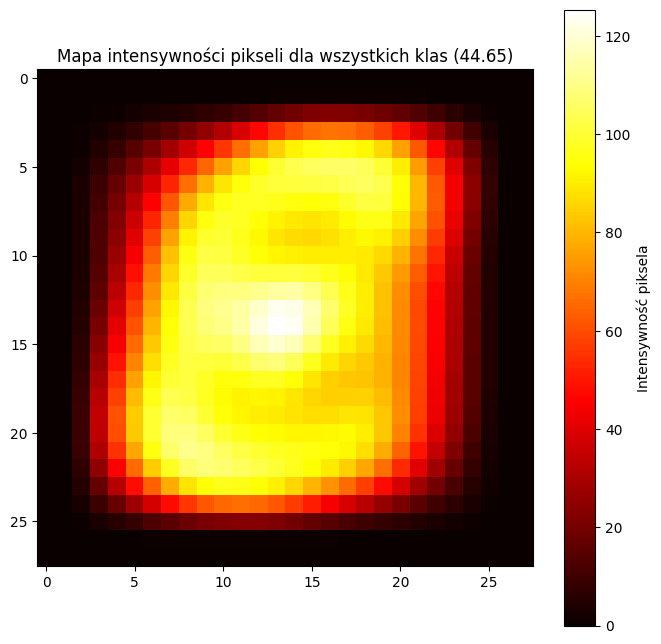

In [16]:
average_image = np.mean(list(average_images.values()), axis=0)

plt.figure(figsize=(8, 8))
plt.imshow(average_image, cmap='hot', interpolation='nearest')
plt.colorbar(label='Intensywność piksela')
plt.title(f'Mapa intensywności pikseli dla wszystkich klas ({np.mean(average_image):.2f})')
plt.show()

Można porównać liczbę średnią liczbę zapalonych pikseli dla przykładów z każdej klasy w bardziej widocznej formie - wykresu słupkowego. Dodamy tu również rekord ALL z naszego uśrednionego przykładu (wyżej). Jak widać na poniższym wykresie, jego średnia wartość zapalonego piksela plasuje się na środku wykresu.<br/><br/>Może być on punktem odniesienia do analizy tego, które klasy wymagają średnio więcej rozświetlonych pikseli, a które mniej.

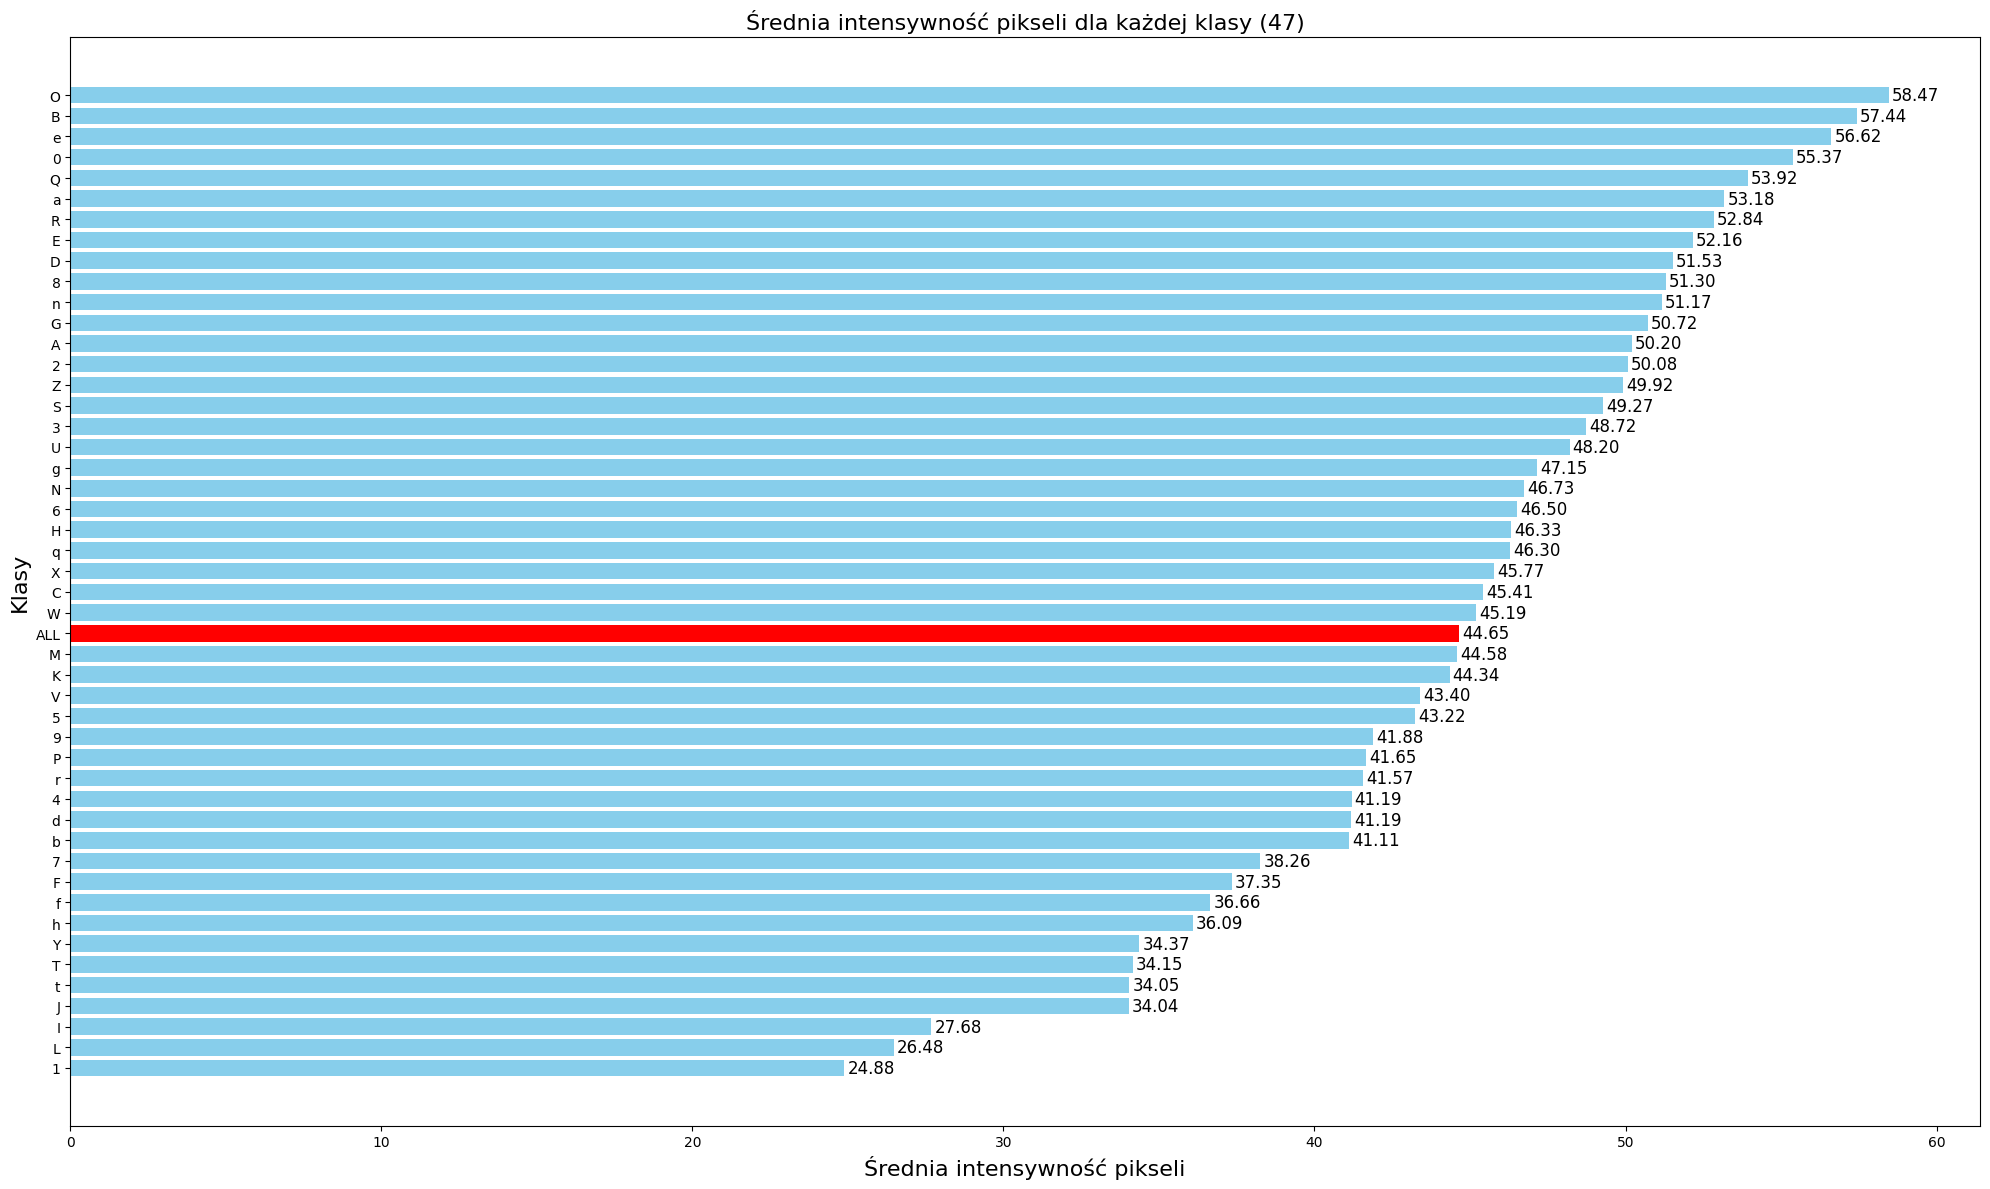

In [17]:
avg_pixels_light = {}

for idx, label in enumerate(mapping_dict.keys()):
    avg_pixels_light[mapping_dict[label]] = np.mean(average_images[label])

avg_pixels_light['ALL'] = np.mean(average_image)
avg_pixels_light = dict(sorted(avg_pixels_light.items(), key=lambda item: item[1]))

plt.figure(figsize=(20, 12))
bars = plt.barh(list(avg_pixels_light.keys()), list(avg_pixels_light.values()), color=['red' if key == 'ALL' else 'skyblue' for key in avg_pixels_light.keys()])

for bar in bars:
    plt.text(bar.get_width() + 0.1, bar.get_y() + bar.get_height() / 2, f"{bar.get_width():.2f}", va='center', fontsize=12)


plt.xlabel('Średnia intensywność pikseli', fontsize=16)
plt.ylabel('Klasy', fontsize=16)
plt.title('Średnia intensywność pikseli dla każdej klasy (47)', fontsize=16)

plt.tight_layout()
plt.show()


## Podobieństwo klas

Na pierwszej mapie ciepła zauważyliśmy, że część klas jest bardzo podobna do siebie - np. 1, I, L. Nawet człowiek może mieć kłopot z rozdzieleniem tych znaków, co może świadczyć o problemach w uczeniu modeli.<br/><br/>
Podzielimy teraz klasy na grupy. Do podziału użyjemy metody k-średnich (KMeans), która wyznacza współrzędne k-punktów, będące środkami k-klastrów. Najbardziej optymalną liczbę grup (klastrów) znajdziemy za pomocą porównania współczynników silhouette (sylwetki) dla różnych liczb grup. Współczynnik określa średnie podobieństwo obiektu do innych obiektów w danym klastrze. Im współczynnik bliższy jest 1, tym lepiej obiekt/obiekty dopasowane są do klastra.


c:\Users\matik\anaconda3\envs\ml\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
c:\Users\matik\anaconda3\envs\ml\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
c:\Users\matik\anaconda3\envs\ml\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
c:\Users\matik\anaconda3\envs\ml\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known

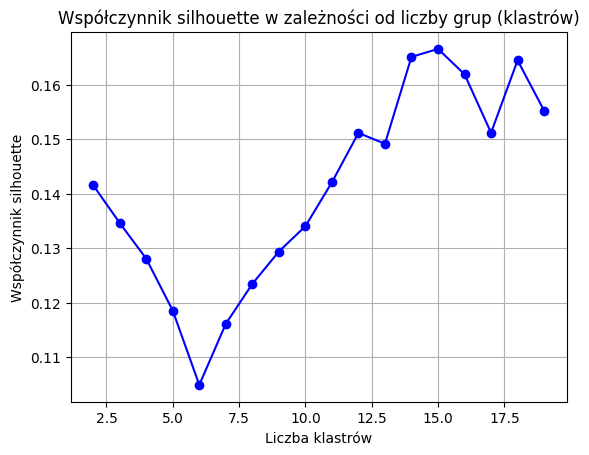

Optymalna liczba klastrów: 15
Grupa 4: ['0', 'D', 'O']
Grupa 3: ['1', 'I', 'L', 't']
Grupa 12: ['2', 'Z']
Grupa 13: ['3', 'B', 'S']
Grupa 1: ['4', 'A', 'H', 'N', 'R', 'd']
Grupa 2: ['5', 'E', 'J', 'T']
Grupa 11: ['6', 'b']
Grupa 5: ['7', '9', 'g', 'q']
Grupa 6: ['8', 'F', 'P', 'f']
Grupa 10: ['C', 'e']
Grupa 7: ['G', 'Q']
Grupa 9: ['K', 'X', 'Y', 'h']
Grupa 8: ['M', 'W']
Grupa 15: ['U', 'V', 'a']
Grupa 14: ['n', 'r']


c:\Users\matik\anaconda3\envs\ml\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


In [18]:
def optimal_clusters_count(X):
    scores = []

    for k in range(2, 20):
        kmeans = KMeans(n_clusters=k, random_state=42)
        labels = kmeans.fit_predict(X)
        score = silhouette_score(X, labels)
        scores.append(score)

    plt.plot(range(2, 20), scores, 'bo-', label='Współczynnik sylwetki')

    plt.title('Współczynnik silhouette w zależności od liczby grup (klastrów)')
    plt.xlabel('Liczba klastrów')
    plt.ylabel('Współczynnik silhouette')

    plt.grid(True)
    plt.show()

    return np.argmax(scores) + 2

average_images_flatten = np.array([image.flatten() for image in average_images.values()])

optimal_n = optimal_clusters_count(average_images_flatten)
print(f"Optymalna liczba klastrów: {optimal_n}")

kmeans = KMeans(n_clusters=optimal_n, random_state=42)
labels = kmeans.fit_predict(average_images_flatten)

grouped_images = {}
for i, label in enumerate(labels):
    image_label = list(average_images.keys())[i]
    if label not in grouped_images:
        grouped_images[label] = []
    grouped_images[label].append(image_label)

for group, images in grouped_images.items():
    print(f"Grupa {group + 1}: {[mapping_dict[im] for im in images]}")


Najlepszy wynik wpółczynnika sylwetki (wykres powyżej) nie przekracza 0.2 (uważa się wynik bliski 1 oznacza dobrą separację obiektów, a 0.25 już za słabą), zatem na wykresie grupowym nie będzie widać dobrego rozróżnienia między poszczególnymi grupami.<br/><br/>
Do wyświetlenia podziału naszych grup użyjemy metody analizy głównych składowych PCA. Zredukujemy nasze dane do 2 wymiarów - osi X i Y.

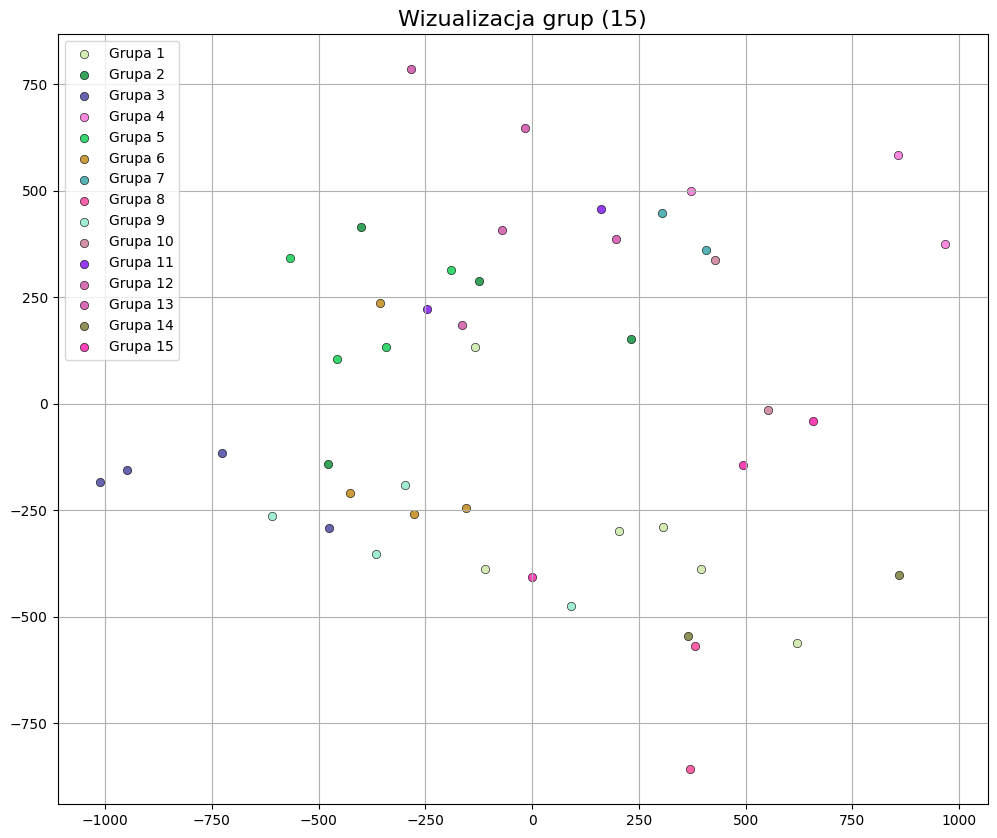

In [19]:
images_2d = PCA(n_components=2).fit_transform(average_images_flatten)

group_distances = {}
for l in range(optimal_n):
    group_indices = np.where(labels == l)[0]
    group_points = average_images_flatten[group_indices]

    # średnia odległość elementów w danym klastrze
    intra_distances = pairwise_distances(group_points).mean()
    group_distances[l] = intra_distances

# losowe kolory dla grup
colors = [tuple(np.random.rand(3)) for _ in range(optimal_n)]

plt.figure(figsize=(12, 10))
for label in range(optimal_n):
    cluster_points = images_2d[labels == label]
    plt.scatter(cluster_points[:, 0], cluster_points[:, 1], 
                label=f'Grupa {label + 1}', 
                color=colors[label], alpha=0.8, edgecolors='black', linewidth=0.5)

plt.title(f'Wizualizacja grup ({optimal_n})', fontsize=16)
plt.legend()
plt.grid(True)
plt.show()


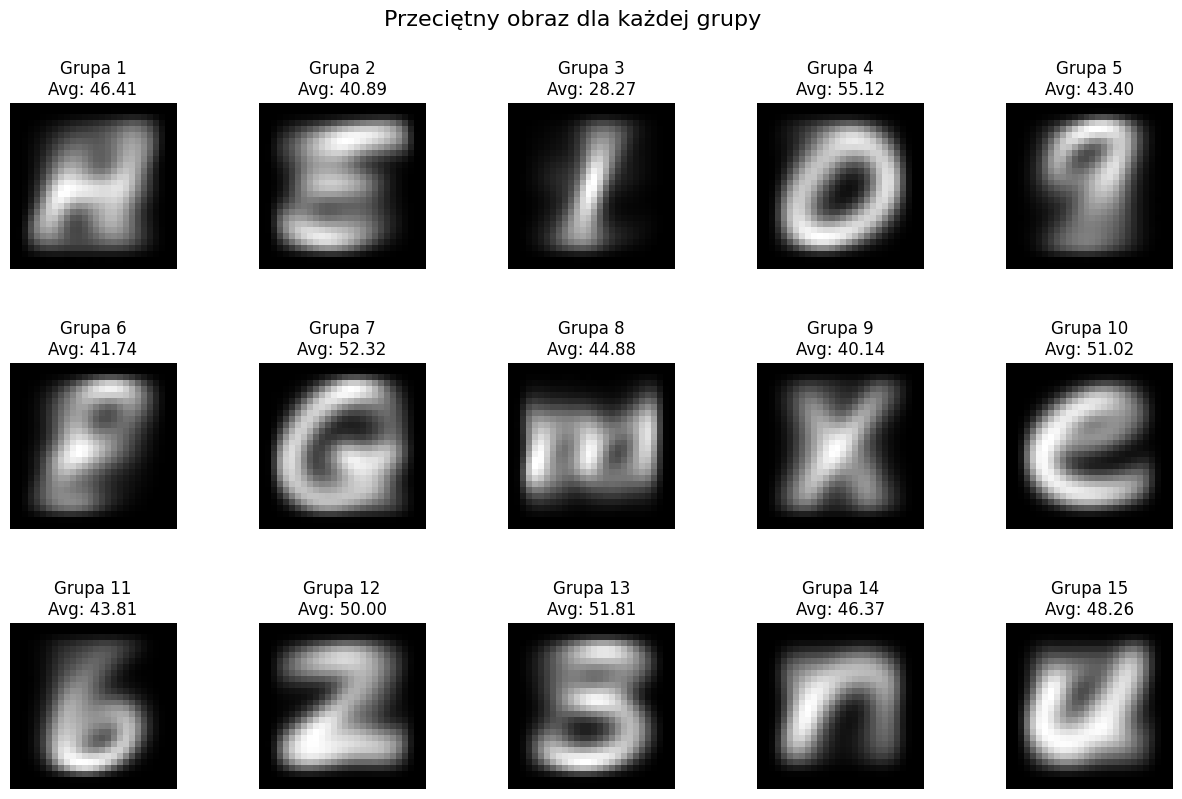

In [20]:
group_avg_images = {}
for label in range(optimal_n):
    # zbieramy etykiety obrazów w danej grupie
    group_indices = np.where(labels == label)[0]
    # i ich obrazy
    group_images = [average_images_flatten[i] for i in group_indices]
    # wyznaczamy przeciętny obraz
    mean_image = np.mean(group_images, axis=0)
    group_avg_images[label] = mean_image.reshape(average_images[next(iter(average_images))].shape)

num_cols = 5
num_rows = (optimal_n + num_cols - 1) // num_cols

fig, axes = plt.subplots(num_rows, num_cols, figsize=(num_cols * 3, num_rows * 3), gridspec_kw={'wspace': 0.5, 'hspace': 0.5})
axes = axes.flatten()

for i, (label, avg_image) in enumerate(group_avg_images.items()):
    ax = axes[i]
    ax.imshow(avg_image, cmap='gray')
    ax.set_title(f'Grupa {label + 1}\nAvg: {np.mean(avg_image):.2f}')

for ax in axes:
    ax.axis('off')

plt.suptitle('Przeciętny obraz dla każdej grupy', fontsize=16)
plt.show()


Wyświetlimy teraz 3 obrazy (lub mniej, w zależności od liczby elementów w grupie) z każdej grupy. Tutaj można zauważyć bardzo duże podobieństwo obrazów w niektórych grupach: 3 (1, I, L), 4 (O, D, 0), 5 (9, G), 10 (C, e), 11 (6, b).

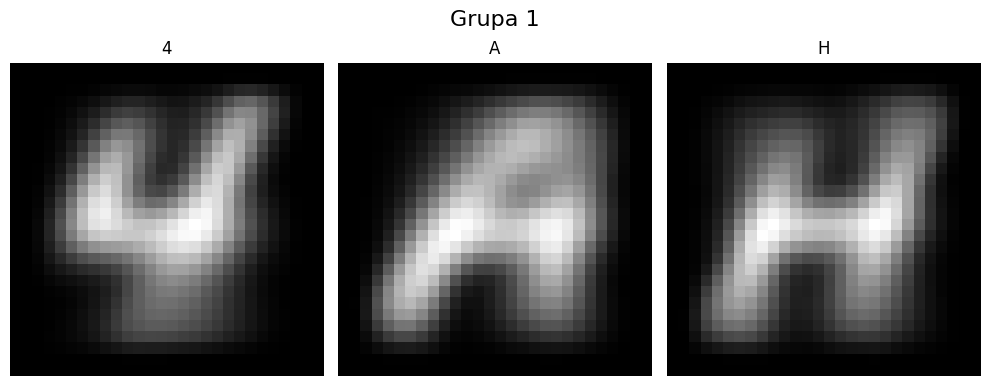

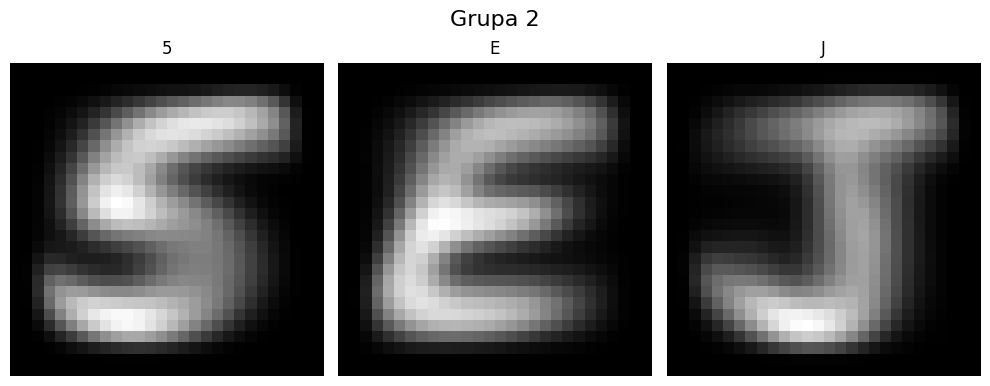

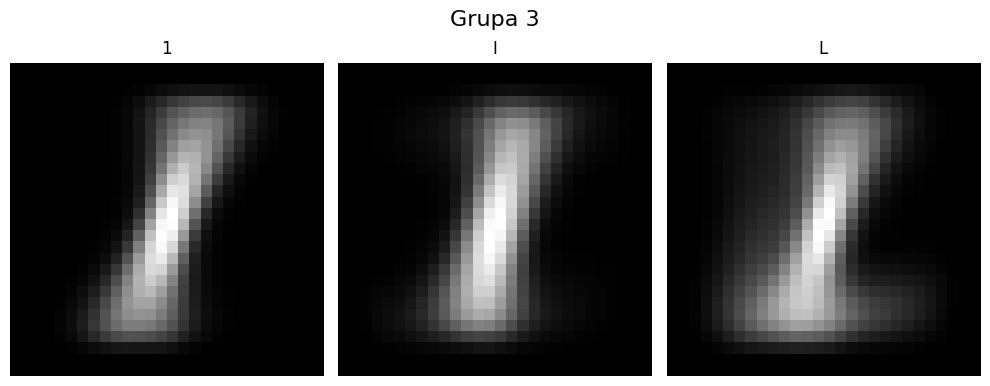

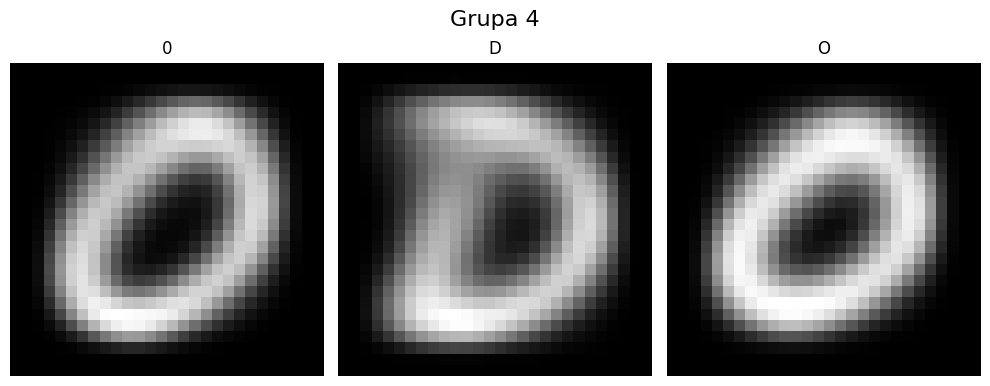

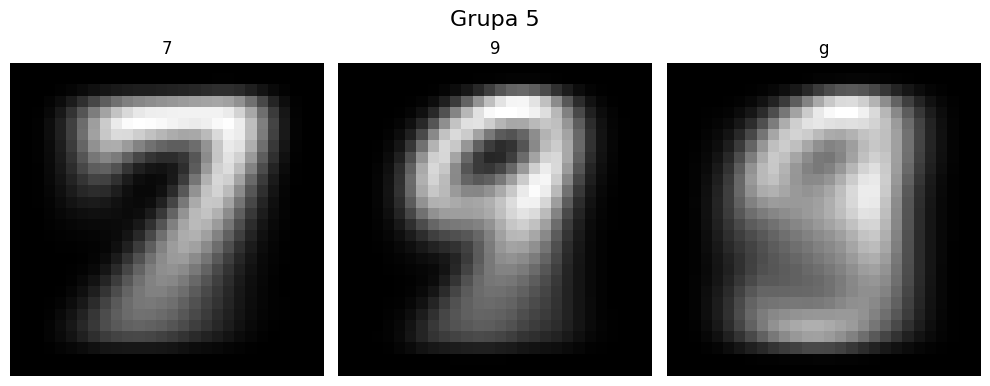

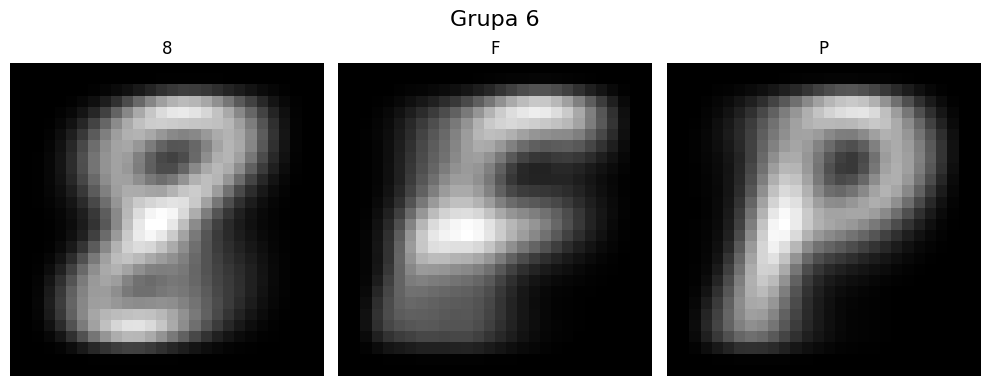

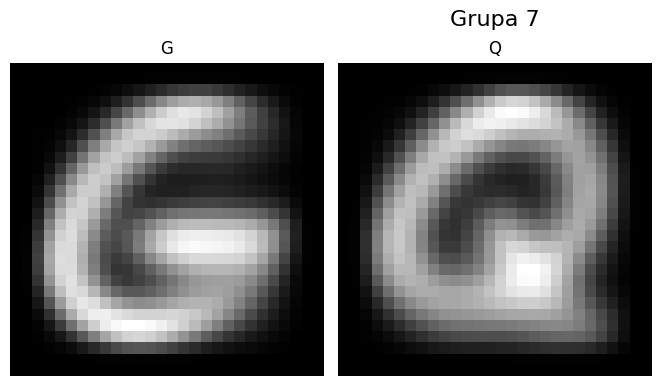

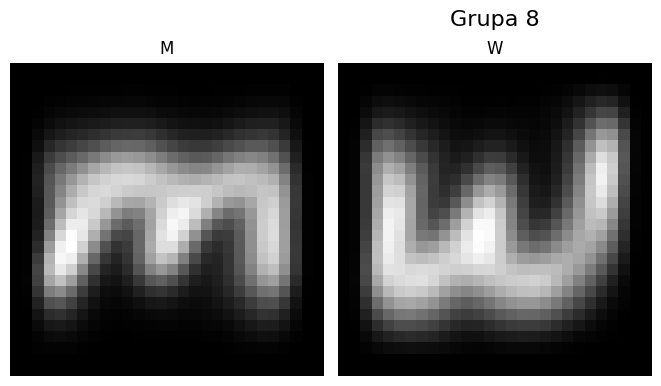

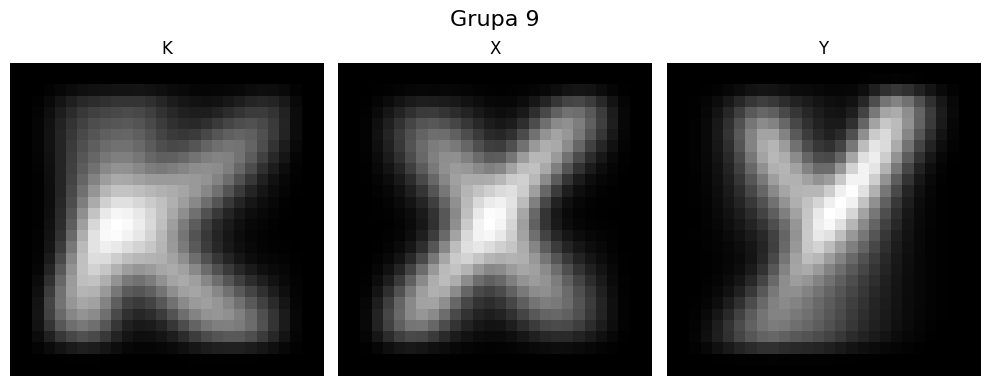

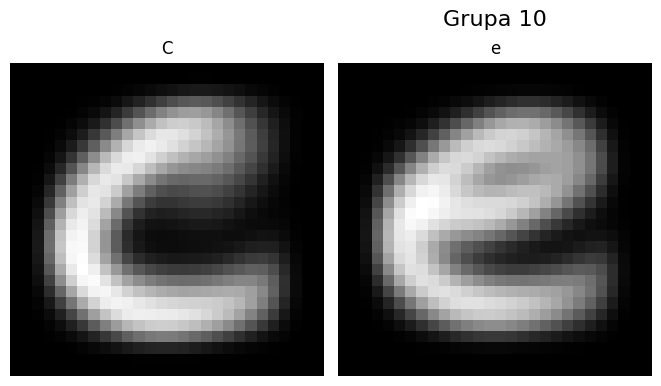

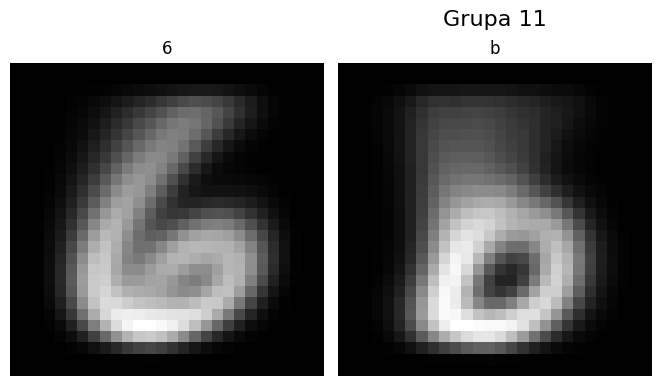

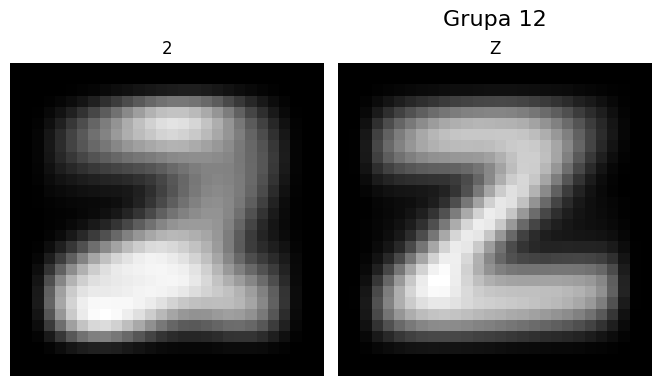

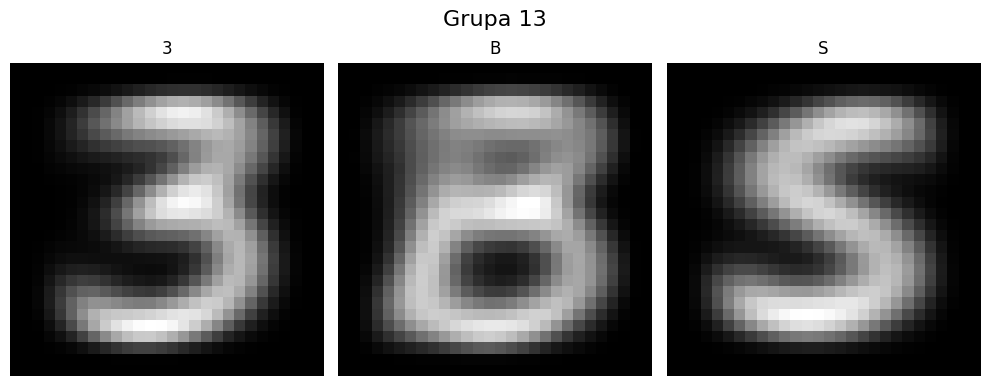

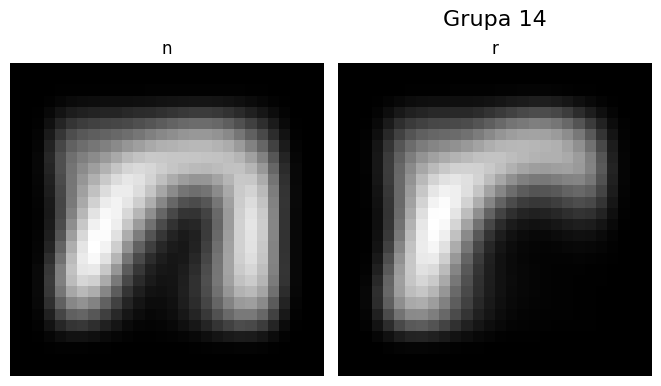

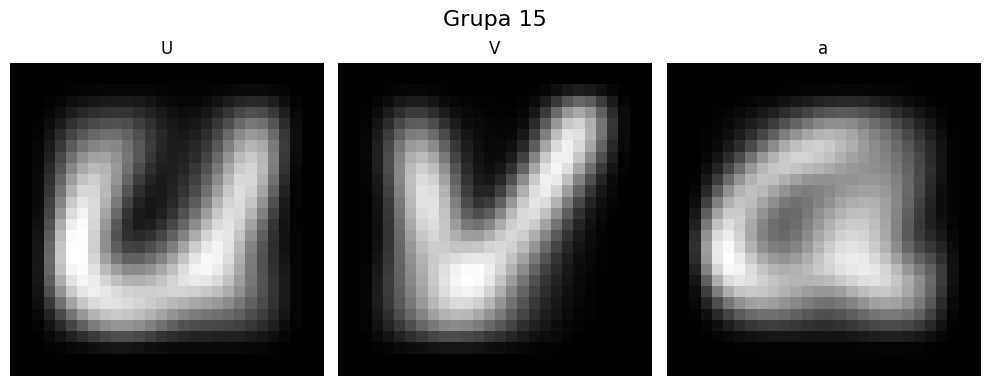

In [21]:
images_per_group = {}

n_images = 3

for label in range(optimal_n):
    group_labels = np.where(labels == label)[0]
    group_images = [average_images_flatten[i] for i in group_labels]
    images_per_group[label] = (group_images[:n_images], group_labels[:n_images])

for label, (top_images, top_indices) in images_per_group.items():
    plt.figure(figsize=(10, 4))
    
    for i, image in enumerate(top_images):
        plt.subplot(1, n_images, i + 1)
        plt.imshow(np.array(image).reshape(average_images[next(iter(average_images))].shape), cmap='gray')
        plt.axis('off')

        plt.title(f'{mapping_dict[top_indices[i]]}')
    
    plt.suptitle(f'Grupa {label + 1}', fontsize=16)
    plt.tight_layout()
    plt.show()


# Trening

In [22]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

#### Definiujemy klasę Dataset PyTorch-a
Podczas pobierania elementów w trakcie treningu, będziemy przekształcać je na tensory i standaryzować wartości pikseli. Wykorzystana zostanie również lekka augmentacja danych (losowe obroty, przesunięcia, skalowanie).

In [109]:
class EMNISTDataset(Dataset):
    def __init__(self, X, y, train=True):
        self.train = train
        self.X = X.astype('float32')
        self.y = y.astype('int64')
        self.transform = transforms.Compose([
            transforms.ToPILImage(),
            transforms.RandomAffine(degrees=10, translate=(0.1, 0.1), scale=(0.9, 1.1)),
            transforms.ToTensor(),
            transforms.Normalize((0.5,), (0.5,))
        ])
        self.process = transforms.Compose([
            transforms.ToPILImage(),
            transforms.ToTensor(),
            transforms.Normalize((0.5,), (0.5,))
        ])

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        X = self.X[idx].reshape(28, 28)
        if self.train:
            X = self.transform(X)
        else:
            X = self.process(X)
        y = self.y[idx]
        return X, y

### Przygotowujemy dane treningowe i testowe dla trenowania modeli
- Normalizujemy wartości pikseli do zakresu [0, 1]
- Dzielimy losowo zbiór treningowy na dane treningowe i walidacyjne w proporcji 80/20
- Tworzymy obiekty Dataset i DataLoader dla danych, aby model mógł pobierać dane w trakcie treningu

In [110]:
X = train.iloc[:, 1:].reset_index(drop=True).values / 255.0
y = train.iloc[:, 0].reset_index(drop=True).values

train_size = int(0.8 * len(X))
val_size = len(X) - train_size

dataset = EMNISTDataset(X, y)
train_dataset, val_dataset = random_split(dataset, [train_size, val_size])

train_dataloader = DataLoader(train_dataset, batch_size=256, shuffle=True)
val_dataloader = DataLoader(val_dataset, batch_size=256, shuffle=False)

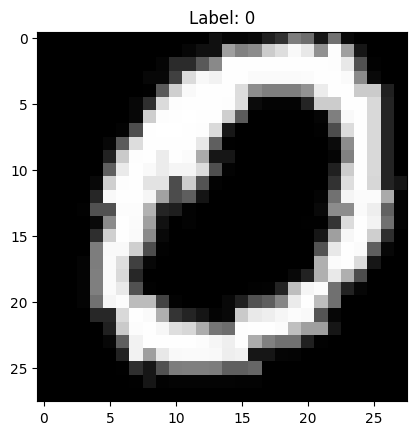

In [111]:
sampleX, sampley = next(iter(train_dataloader))

sampleX.shape, sampley.shape

image = sampleX[0].squeeze()

plt.imshow(image, cmap='gray')
plt.title(f'Label: {mapping_dict[sampley[0].item()]}')
plt.show()

#### Definiujemy architektury modeli konwolucyjnych sieci neuronowych
(Z wykorzystaniem biblioteki PyTorch)

- Szczegółowe omówienie budowy sieci oraz przebiegu trenowania znajduje się w sekcji "Porównanie modeli".

In [26]:
import torch
import torch.nn.functional as F
import torch.nn as nn

class ResidualBlock(nn.Module):
    def __init__(self, in_channels, out_channels, stride=1, downsample=None):
        super(ResidualBlock, self).__init__()
        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=stride, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(out_channels)
        self.relu = nn.ReLU(inplace=True)
        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(out_channels)
        self.downsample = downsample

    def forward(self, x):
        identity = x
        if self.downsample is not None:
            identity = self.downsample(x)

        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)
        out = self.conv2(out)
        out = self.bn2(out)
        
        out += identity
        out = self.relu(out)

        return out

class ResNet(nn.Module):
    def __init__(self, block, layers, num_classes=47):
        super(ResNet, self).__init__()
        self.in_channels = 64
        self.conv1 = nn.Conv2d(1, 64, kernel_size=7, stride=2, padding=3, bias=False)
        self.bn1 = nn.BatchNorm2d(64)
        self.relu = nn.ReLU(inplace=True)
        self.maxpool = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)

        self.layer1 = self._make_layer(block, 64, layers[0])
        self.layer2 = self._make_layer(block, 128, layers[1], stride=2)
        self.layer3 = self._make_layer(block, 256, layers[2], stride=2)
        self.layer4 = self._make_layer(block, 512, layers[3], stride=2)

        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
        self.fc = nn.Linear(512, num_classes)

    def _make_layer(self, block, out_channels, blocks, stride=1):
        downsample = None
        if stride != 1 or self.in_channels != out_channels:
            downsample = nn.Sequential(
                nn.Conv2d(self.in_channels, out_channels, kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(out_channels),
            )

        layers = []
        layers.append(block(self.in_channels, out_channels, stride, downsample))
        self.in_channels = out_channels
        for _ in range(1, blocks):
            layers.append(block(out_channels, out_channels))

        return nn.Sequential(*layers)

    def forward(self, x):
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.maxpool(x)

        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)

        x = self.avgpool(x)
        x = torch.flatten(x, 1)
        x = self.fc(x)

        return x

class CNNBlock(nn.Module):
    def __init__(self, in_channels, out_channels, **kwargs):
        super().__init__()
        self.conv = nn.Conv2d(in_channels, out_channels, **kwargs)
        self.bn = nn.BatchNorm2d(out_channels)
        self.drop = nn.Dropout(0.2)
        
    def forward(self, x):
        x = F.relu(self.conv(x))
        x = self.bn(x)
        x = self.drop(x)
        return x

class SimpleCNN(nn.Module):
    def __init__(self):
        super().__init__()
        self.layer1 = CNNBlock(1, 64, kernel_size=2, padding=1)
        self.layer2 = CNNBlock(64, 128, kernel_size=2, padding=1)
        self.layer3 = CNNBlock(128, 256, kernel_size=2, padding=1)
        self.gap = nn.AdaptiveAvgPool2d(1)
        self.fc = nn.Linear(256, 47)
        
    def forward(self, x):
        x = self.layer1(x)
        x = F.max_pool2d(x, 2)
        x = self.layer2(x)
        x = F.max_pool2d(x, 2)
        x = self.layer3(x)
        x = self.gap(x)
        x = x.view(x.size(0), -1)
        x = self.fc(x)
         
        return x
    

class SimpleCNNWide(nn.Module):
    def __init__(self):
        super().__init__()
        self.layer1 = CNNBlock(1, 128, kernel_size=2, padding=1)
        self.layer2 = CNNBlock(128, 256, kernel_size=2, padding=1)
        self.layer3 = CNNBlock(256, 512, kernel_size=2, padding=1)
        self.gap = nn.AdaptiveAvgPool2d(1)
        self.fc = nn.Linear(512, 47)
        
    def forward(self, x):
        x = self.layer1(x)
        x = F.max_pool2d(x, 2)
        x = self.layer2(x)
        x = F.max_pool2d(x, 2)
        x = self.layer3(x)
        x = self.gap(x)
        x = x.view(x.size(0), -1)
        x = self.fc(x)
         
        return x

class SimpleCNNDeep(nn.Module):
    def __init__(self):
        super().__init__()
        self.layer1 = CNNBlock(1, 32, kernel_size=2, padding=1)
        self.layer2 = CNNBlock(32, 64, kernel_size=2, padding=1)
        self.layer3 = CNNBlock(64, 128, kernel_size=2, padding=1)
        self.layer4 = CNNBlock(128, 256, kernel_size=2, padding=1)
        self.gap = nn.AdaptiveAvgPool2d(1)
        self.fc = nn.Linear(256, 47)
        
    def forward(self, x):
        x = self.layer1(x)
        x = F.max_pool2d(x, 2)
        x = self.layer2(x)
        x = F.max_pool2d(x, 2)
        x = self.layer3(x)
        x = F.max_pool2d(x, 2)
        x = self.layer4(x)
        x = self.gap(x)
        x = x.view(x.size(0), -1)
        x = self.fc(x)
        return x

In [27]:
models = {
    "simple-base": SimpleCNN().to(device),
    "simple-deep": SimpleCNNDeep().to(device),
    "simple-wide": SimpleCNNWide().to(device),
    "resnet": ResNet(ResidualBlock, layers=[1, 1, 1, 1], num_classes=47).to(device),
}

Będziemy przez każdy model przepuszczać po 20 razy dane treningowe.

In [28]:
EPOCHS = 20

Trenowanie modeli:

In [ ]:
criterion = nn.CrossEntropyLoss() # funkcja straty
scaler = GradScaler() # automatyczne skalowanie gradientów dla poprawy wydajności

# Trenowanie każdego modelu po kolei
for model_name, model in models.items():
    print(f"\nTrenowanie {model_name}")
    optimizer = optim.Adam(model.parameters(), lr=1e-3, weight_decay=1e-4) # definiujemy optymalizator
    scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=5) # definiujemy harmonogram lr
    
    # Listy do przechowywania wyników modeli na przestrzeni uczenia
    train_losses = []
    train_accuracies = []
    val_losses = []
    val_accuracies = []

    # Pojedyncza epoka (model przechodzi raz przez cały zbiór danych)
    for epoch in range(EPOCHS):
        model.train() # ustawienie modelu w tryb trenowania
        train_loss = 0.0
        train_correct = 0
        train_total = 0
        
        # Pasek postępu
        train_progress_bar = tqdm(train_dataloader, desc=f"Epoch {epoch+1}/{EPOCHS} [Train - {model_name}]", leave=False)

        for inputs, labels in train_progress_bar:
            inputs, labels = inputs.to(device), labels.to(device) # przesłanie danych na GPU

            with autocast("cuda"):
                outputs = model(inputs) # przejście danych przez model
                loss = criterion(outputs, labels) # oblinczenie straty dla tych przewidywań

            optimizer.zero_grad() # wyzerowanie gradientów
            scaler.scale(loss).backward() # obliczenie gradientów
            scaler.step(optimizer) # aktualizacja wag
            scaler.update()

            train_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            train_correct += (predicted == labels).sum().item()
            train_total += labels.size(0)

            train_progress_bar.set_postfix(loss=loss.item(), accuracy=100 * train_correct / train_total)

        train_epoch_loss = train_loss / len(train_dataloader)
        train_epoch_accuracy = 100 * train_correct / train_total
        train_accuracies.append(train_epoch_accuracy)

        # Walidacja na zbiorze walidacyjnym
        model.eval() # ustawienie modelu w tryb ewaluacji
        val_loss = 0.0
        val_correct = 0
        val_total = 0
        val_progress_bar = tqdm(val_dataloader, desc=f"Epoch {epoch+1}/{EPOCHS} [Val - {model_name}]", leave=False)

        with torch.no_grad():
            for inputs, labels in val_progress_bar:
                inputs, labels = inputs.to(device), labels.to(device)

                with autocast("cuda"):
                    outputs = model(inputs)
                    loss = criterion(outputs, labels)

                val_loss += loss.item()
                _, predicted = torch.max(outputs, 1)
                val_correct += (predicted == labels).sum().item()
                val_total += labels.size(0)

                val_progress_bar.set_postfix(loss=loss.item(), accuracy=100 * val_correct / val_total)

        val_epoch_loss = val_loss / len(val_dataloader)
        val_epoch_accuracy = 100 * val_correct / val_total
        val_accuracies.append(val_epoch_accuracy)

        print(f"{model_name} - Epoka {epoch+1}/{EPOCHS}, "
              f"Strata treningowa: {train_epoch_loss:.4f}, Dokładność treningowa: {train_epoch_accuracy:.2f}%, "
              f"Strata walidacyjna: {val_epoch_loss:.4f}, Dokładność walidacyjna: {val_epoch_accuracy:.2f}%")

        scheduler.step(val_epoch_loss)

    print(f"Trening zakończony {model_name}")

Teraz zapiszemy historię trenowania w postaci wykresów do plików.

In [ ]:
# Zapisz
def plot_training_history():
    epochs = range(1, EPOCHS + 1)
    
    # Strata
    plt.figure(figsize=(10, 5))
    plt.subplot(1, 2, 1)
    plt.plot(epochs, train_losses, 'b-', label='Strata treningowa')
    plt.plot(epochs, val_losses, 'r-', label='Strata walidacyjna')
    plt.title('Strata treningowa i walidacyjna')
    plt.xlabel('Epoka')
    plt.ylabel('Strata')
    plt.legend()
    plt.xlim(1, EPOCHS)
    plt.ylim(0, 2)
    
    # Dokładność
    plt.subplot(1, 2, 2)
    plt.plot(epochs, train_accuracies, 'b-', label='Dokładność treningowa')
    plt.plot(epochs, val_accuracies, 'r-', label='Dokładność walidacyjna')
    plt.title('Dokładność treningowa i walidacyjna')
    plt.xlabel('Epoka')
    plt.ylabel('Dokładność [%]')
    plt.legend()
    plt.xlim(1, EPOCHS)
    plt.ylim(0, 100)
    
    plt.tight_layout()
    plt.savefig('training_history_deep.png')
    plt.close()


plot_training_history()

<h2>Zapisanie modeli</h2>

Zapisujemy wyuczone wagi modeli w celu dalszej analizy ich wyników.

In [98]:
for model_name, model in models.items():
    torch.save(model.state_dict(), f'models/{model_name}.pth')

# Porównanie modeli

### Modele wybrane do porównania:

#### 1. Prosta sieć neuronowa złożona z:
trzech bloków, zawierających:
- warstwę konwolucyjną
- funkcję aktywacji ReLU
- normalizację wsadową
- warstwę dropout (p = 0.2)
- warstwę poolingową typu Max

na końcu:
- warstwę poolingu adaptacyjnego z biblioteki PyTorch, która dostosowuje rozmiar map cech do ustalonego rozmiaru wyjściowego
- warstwę w pełni połączoną, która przekształca wejście do 47 klas (liczba klas w zbiorze EMNIST)

Ta sieć została przetestowana 3-krotnie, przyjmując różne jej warianty:
- A. Wersja bazowa (liczba warstw: 3, liczba filtrów: 64, 128, 256)
- B. Wersja "głębsza" (liczba warstw: 4, liczba filtrów: 32, 64, 128, 256)
- C. Wersja "szersza" (liczba warstw: 3, liczba filtrów: 128, 256, 512)

#### 2. Model oparty o architekturę ResNet wytrenowaną od zera (w okrojonej formie, ponieważ zbiór danych jest dość prosty)
Dla porównania: ResNet18 składa się z 4 bloków (w każdym 2 bloki resztkowe), a nasz model składa się z 4 bloków (w każdym 1 blok resztkowy).

#### Każdy z modeli trenowany był:
- przez 20 epok
- z wykorzystaniem optymalizatora Adam (momentum=0.9)
- za pomocą funkcji straty Entropii Krzyżowej
- z wykorzystaniem współczynnika uczenia równego: 1e-3
- zastosowano harmonogram współczynnika uczenia: zmniejszenie wartości x10 po 5 epokach braku poprawy straty na zbiorze walidacyjnym
- zastosowano regularyzację w postaci normy L2 (lambda=1e-4) w celu zapobiegania przeuczeniu
- rozmiar mini-paczki danych: 256
- wykorzystana augmentacja w postaci niewielkiego, losowego: skalowania, obrotu i przesunięcia

#### Poniżej przedstawiono przebiegi uczenia dla każdego z modeli

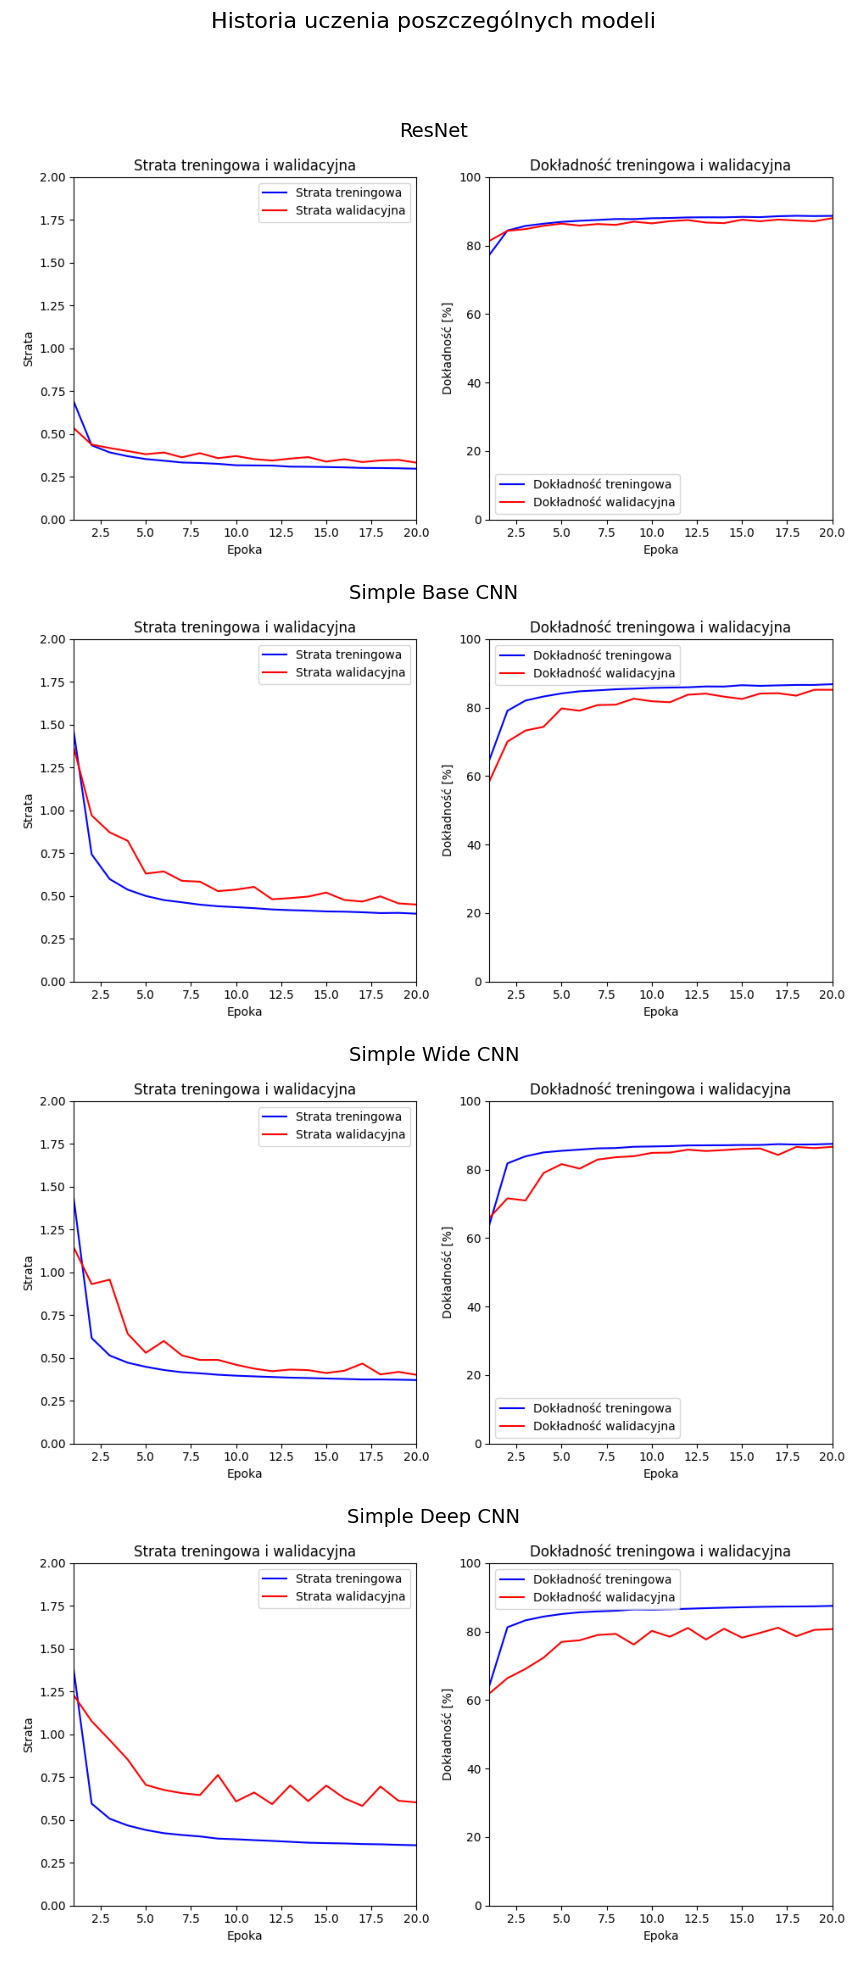

In [29]:
# Wyświetlenie przebiegów uczenia modeli
resnet_wykres = "wykresy/training_history_resnet.png"
simple_base_wykres = "wykresy/training_history_base.png"
simple_wide_wykres = "wykresy/training_history_wide.png"
simple_deep_wykres = "wykresy/training_history_deep.png"

fig, axs = plt.subplots(4, 1, figsize=(20, 20))
plt.suptitle('Historia uczenia poszczególnych modeli', fontsize=16)

images = [resnet_wykres, simple_base_wykres, simple_wide_wykres, simple_deep_wykres]
titles = ['ResNet', 'Simple Base CNN', 'Simple Wide CNN', 'Simple Deep CNN']

for i, (img_path, title) in enumerate(zip(images, titles)):
    img = plt.imread(img_path)
    axs[i].imshow(img)
    axs[i].set_title(title, fontsize=14)
    axs[i].axis('off')


plt.subplots_adjust(top=0.93)
plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()


#### Wnioski płynące z analizy przebiegów uczenia
ResNet:
Strata treningowa i walidacyjna maleje stabilnie w miarę postępu epok, co świadczy o efektywnym uczeniu modelu.
Dokładność treningowa i walidacyjna osiąga wysokie wartości, co oznacza, że model dobrze dopasowuje się do danych treningowych i walidacyjnych.
Brak znaczących różnic między stratą i dokładnością na zbiorach treningowych i walidacyjnych wskazuje na niskie ryzyko przeuczenia.

Simple Base CNN:
Strata treningowa i walidacyjna również maleje, ale różnica między nimi jest większa niż w przypadku ResNet.
Dokładność na zbiorze walidacyjnym jest nieco niższa niż na treningowym, co może wskazywać na lekkie przeuczenie.
Model osiąga przyzwoitą dokładność, ale nie jest tak skuteczny jak ResNet.

Simple Wide CNN:
Straty treningowa i walidacyjna są zbliżone i maleją stabilnie, co wskazuje na dobrą ogólną zdolność generalizacji.
Dokładności treningowa i walidacyjna są porównywalne do Simple Base CNN, ale model wydaje się bardziej stabilny (mniej różnic między treningiem a walidacją).
Model dobrze radzi sobie z uczeniem, osiągając satysfakcjonujące wyniki.

Simple Deep CNN:
Straty treningowa i walidacyjna wykazują większe fluktuacje, szczególnie na zbiorze walidacyjnym, co może świadczyć o problemach z konwergencją lub niestabilnością uczenia.
Dokładność walidacyjna jest zauważalnie niższa niż dokładność treningowa, co sugeruje, że model jest podatny na przeuczenie.
Model może wymagać optymalizacji (np. modyfikacji architektury, regularyzacji lub dostosowania hiperparametrów).

Ogólne wnioski:
ResNet jest najbardziej stabilnym i skutecznym modelem, charakteryzującym się wysoką dokładnością i dobrą generalizacją.
Proste modele CNN (Base, Wide, Deep) różnią się między sobą wynikami. Wide CNN wydaje się lepiej dopasowywać i generalizować niż Base i Deep.
Simple Deep CNN wykazuje problemy z generalizacją i może wymagać poprawy w zakresie regularyzacji (np. dropout) lub lepszej inicjalizacji wag.

#### Wczytanie wytrenowanych wag wszystkich modeli w celu porównania

In [30]:
resnet = ResNet(ResidualBlock, [1, 1, 1, 1], num_classes=47).to(device)
resnet.load_state_dict(torch.load("modele/resnet.pth"))

simple_base = SimpleCNN().to(device)
simple_base.load_state_dict(torch.load("modele/simple-base.pth"))

simple_wide = SimpleCNNWide().to(device)
simple_wide.load_state_dict(torch.load("modele/simple-wide.pth"))

simple_deep = SimpleCNNDeep().to(device)
simple_deep.load_state_dict(torch.load("modele/simple-deep.pth"))

models = [resnet, simple_base, simple_wide, simple_deep]

C:\Users\matik\AppData\Local\Temp\ipykernel_29424\1504370512.py:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  resnet.load_state_dict(torch.load("modele/resnet.pth"))
C:\U

#### Poniżej definujemy funkcję, która pozwoli nam na porównanie wyników modeli w postaci: raportu klasyfikacji scikit-learn oraz macierzy pomyłek

In [31]:
def ocen_model(model, dataloader, class_names, true_labels):
    print(f'Model: {model.__class__.__name__}')
    model.eval()
    all_preds = []
    
    with torch.no_grad():
        for inputs, _ in dataloader:
            inputs = inputs.to(device)
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            all_preds.extend(preds.cpu().numpy())
    
    y_pred = np.array(all_preds)
    acc = accuracy_score(true_labels, y_pred)
    print(f'Dokładność: {acc:.4f}')
    print(f'Raport klasyfikacji:\n{classification_report(true_labels, y_pred)}')
    
    cm = confusion_matrix(true_labels, y_pred)
    plt.figure(figsize=(15, 15))
    plt.title(f'Macierz pomyłek dla modelu {model.__class__.__name__}')
    sns.heatmap(cm, annot=True, fmt='d', xticklabels=class_names.values(), 
                yticklabels=class_names.values())
    plt.show()

#### Poniżej wczytujemy dane testowe i przetwarzamy je w taki sam sposób, jak dane treningowe. Nie wykonujemy natomiast augmentacji danych.

In [112]:
# podział danych na dane i etykiety + normalizacja
X_test = test.iloc[:, 1:].values / 255.0
y_test = test.iloc[:, 0].values

# mapowanie indeksów klas na etykiety
class_names = {mapping.iloc[i, 0]: chr(mapping.iloc[i, 1]) for i in range(len(mapping))}

# utworzenie datasetu i dataloadera testowych
test_dataset = EMNISTDataset(X_test, y_test, train=False)
test_dataloader = DataLoader(test_dataset, batch_size=256, shuffle=False)

#### Dla każdego modelu uruchamiam funkcję ocen_model, która przeprowadza klasyfikację, mierzy dokładność, inne metryki oraz wyświetla macierz pomyłek w postaci mapy ciepła.

Model: ResNet
Dokładność: 0.8885
Raport klasyfikacji:
              precision    recall  f1-score   support

           0       0.65      0.74      0.69       400
           1       0.50      0.81      0.62       400
           2       0.94      0.86      0.90       400
           3       0.99      0.98      0.99       400
           4       0.97      0.94      0.95       400
           5       0.99      0.80      0.88       400
           6       0.96      0.93      0.94       400
           7       0.95      0.99      0.97       400
           8       0.95      0.96      0.96       400
           9       0.63      0.94      0.75       400
          10       0.98      0.96      0.97       400
          11       0.97      0.97      0.97       400
          12       0.97      0.96      0.96       400
          13       0.95      0.90      0.92       400
          14       0.98      0.98      0.98       400
          15       0.68      0.67      0.67       400
          16       0.90    

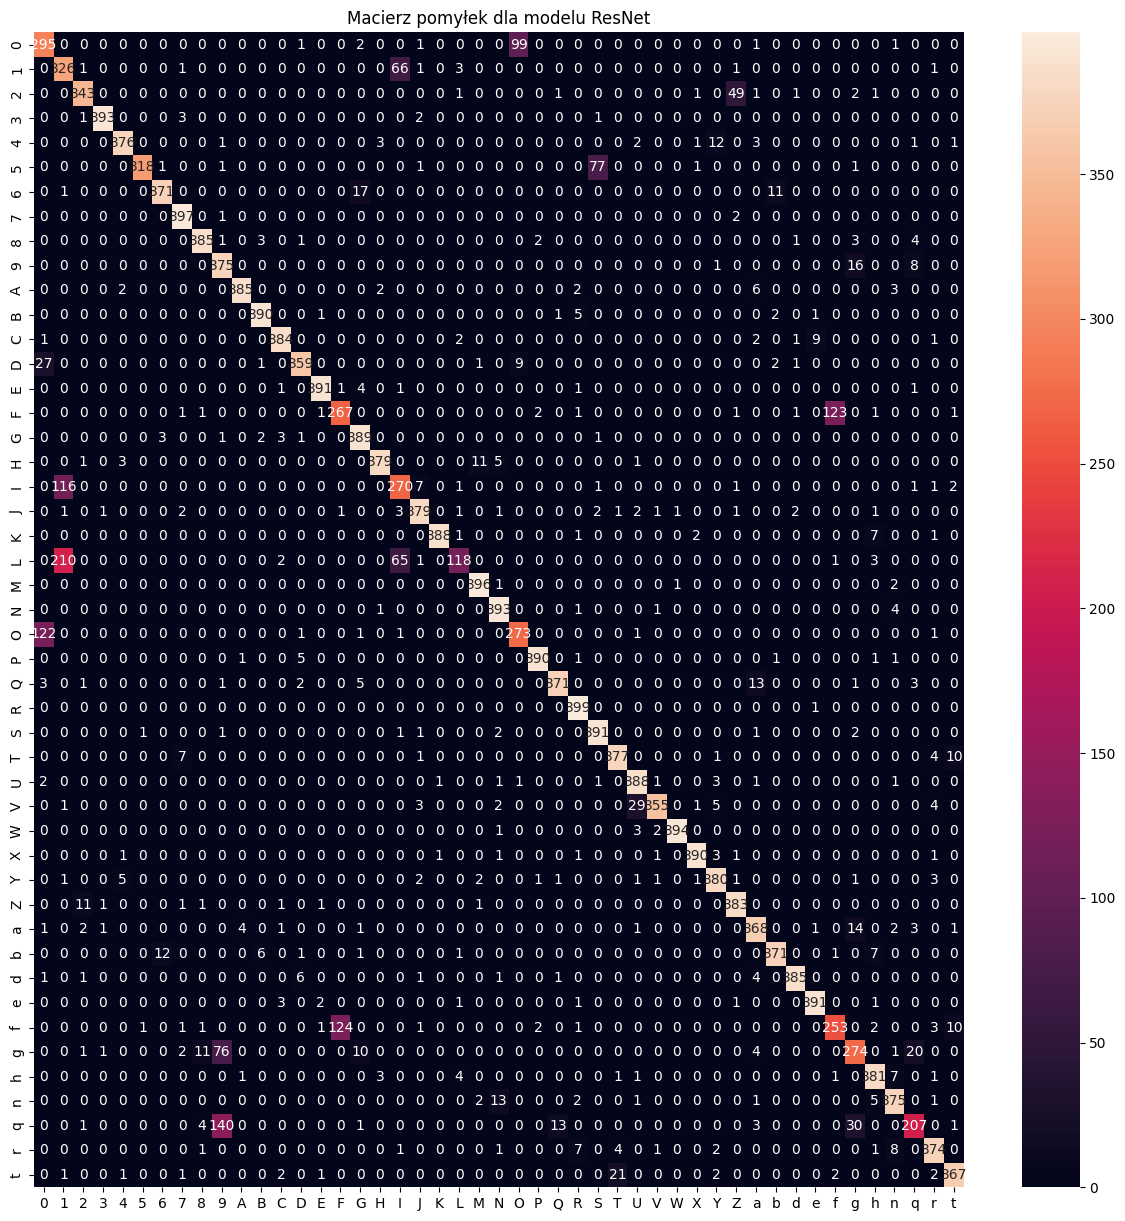

Model: SimpleCNN
Dokładność: 0.8637
Raport klasyfikacji:
              precision    recall  f1-score   support

           0       0.65      0.70      0.68       400
           1       0.60      0.34      0.43       400
           2       0.86      0.92      0.89       400
           3       0.98      0.99      0.99       400
           4       0.92      0.95      0.93       400
           5       0.97      0.78      0.86       400
           6       0.91      0.96      0.93       400
           7       0.94      0.98      0.96       400
           8       0.96      0.94      0.95       400
           9       0.68      0.82      0.74       400
          10       0.98      0.93      0.96       400
          11       0.99      0.93      0.96       400
          12       0.91      0.95      0.93       400
          13       0.96      0.84      0.89       400
          14       0.98      0.97      0.98       400
          15       0.78      0.42      0.55       400
          16       0.96 

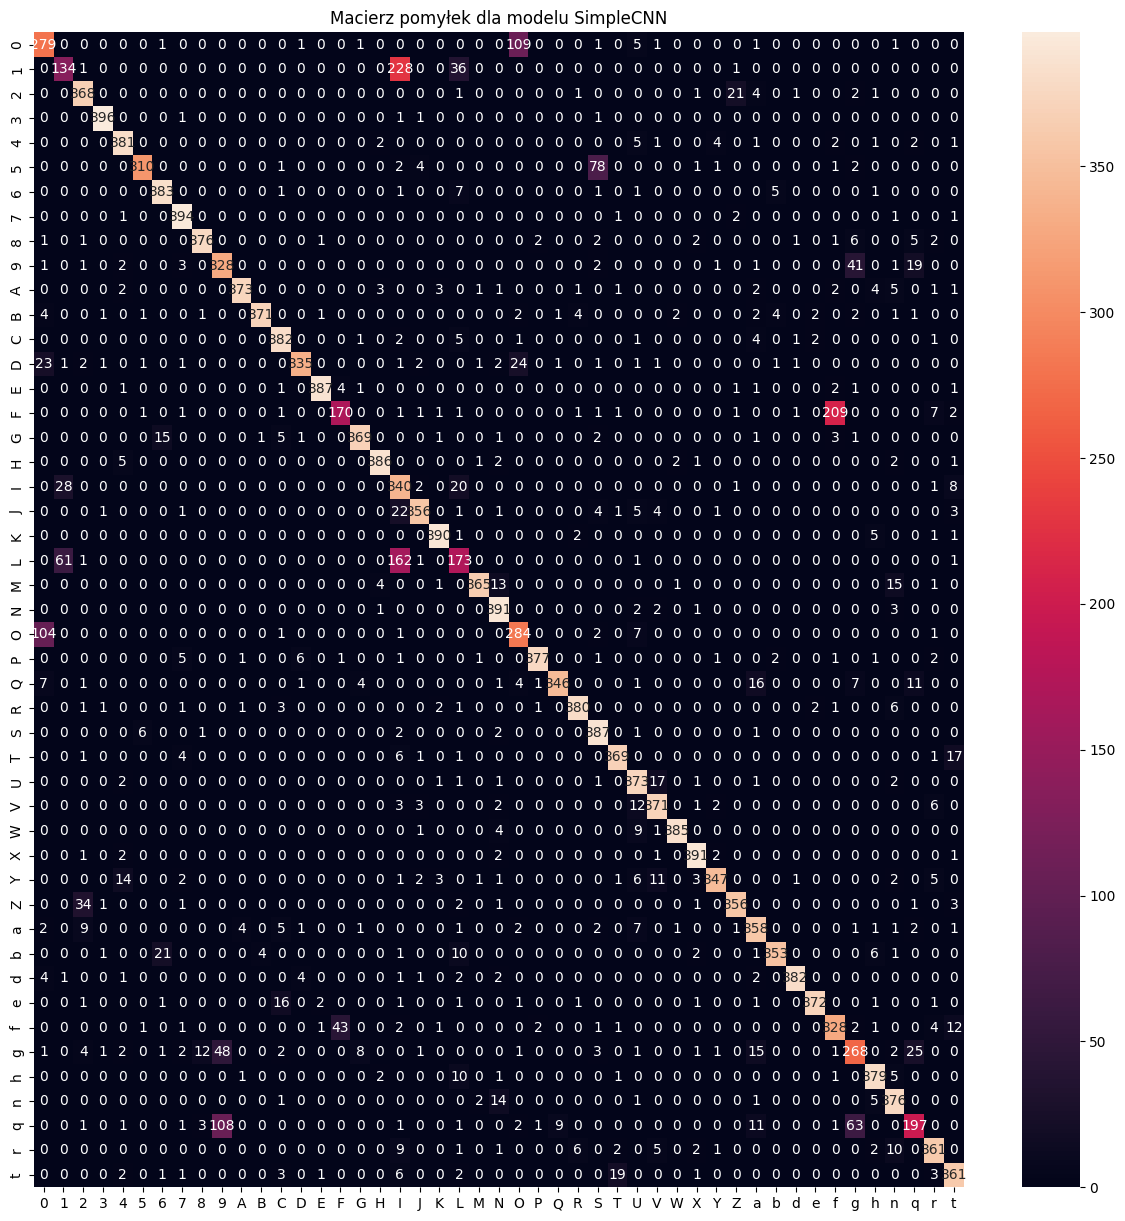

Model: SimpleCNNWide
Dokładność: 0.8800
Raport klasyfikacji:
              precision    recall  f1-score   support

           0       0.65      0.71      0.68       400
           1       0.53      0.72      0.61       400
           2       0.86      0.94      0.90       400
           3       0.99      0.99      0.99       400
           4       0.97      0.90      0.93       400
           5       0.94      0.90      0.92       400
           6       0.85      0.98      0.91       400
           7       0.98      0.99      0.98       400
           8       0.93      0.97      0.95       400
           9       0.71      0.73      0.72       400
          10       0.96      0.98      0.97       400
          11       0.99      0.96      0.98       400
          12       0.95      0.94      0.95       400
          13       0.95      0.89      0.92       400
          14       0.98      0.95      0.97       400
          15       0.75      0.60      0.67       400
          16       0

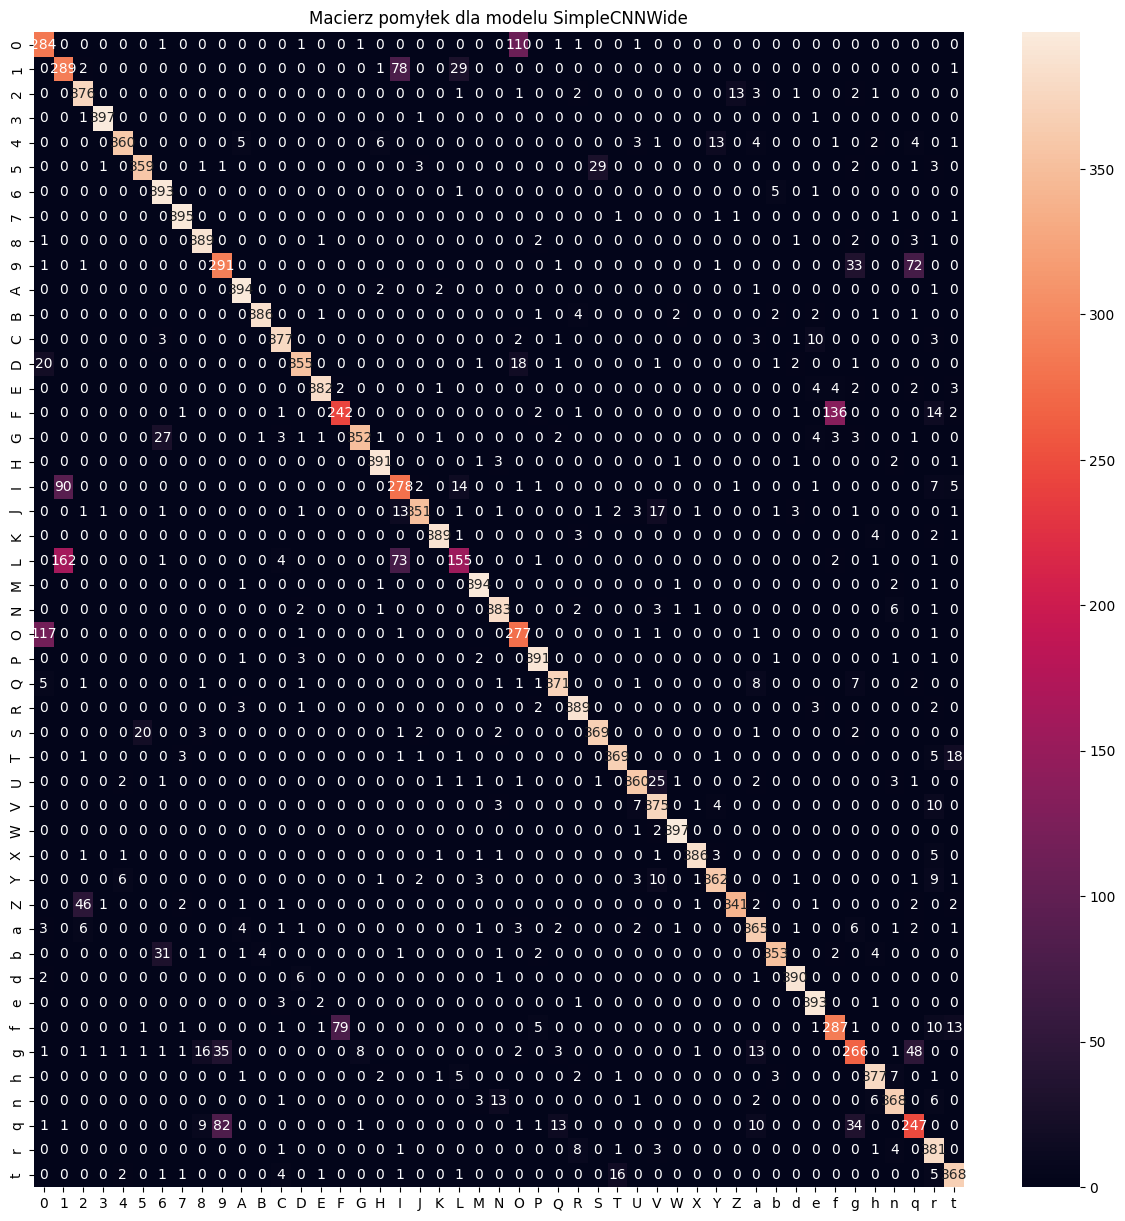

Model: SimpleCNNDeep
Dokładność: 0.8197
Raport klasyfikacji:
              precision    recall  f1-score   support

           0       0.64      0.34      0.44       400
           1       0.50      0.00      0.00       400
           2       0.92      0.91      0.91       400
           3       0.98      0.96      0.97       400
           4       0.92      0.94      0.93       400
           5       1.00      0.39      0.56       400
           6       0.90      0.91      0.90       400
           7       0.98      0.92      0.95       400
           8       0.96      0.90      0.93       400
           9       0.66      0.82      0.73       400
          10       0.96      0.97      0.97       400
          11       0.99      0.88      0.93       400
          12       0.73      0.97      0.84       400
          13       0.96      0.76      0.85       400
          14       0.98      0.93      0.96       400
          15       0.70      0.43      0.53       400
          16       0

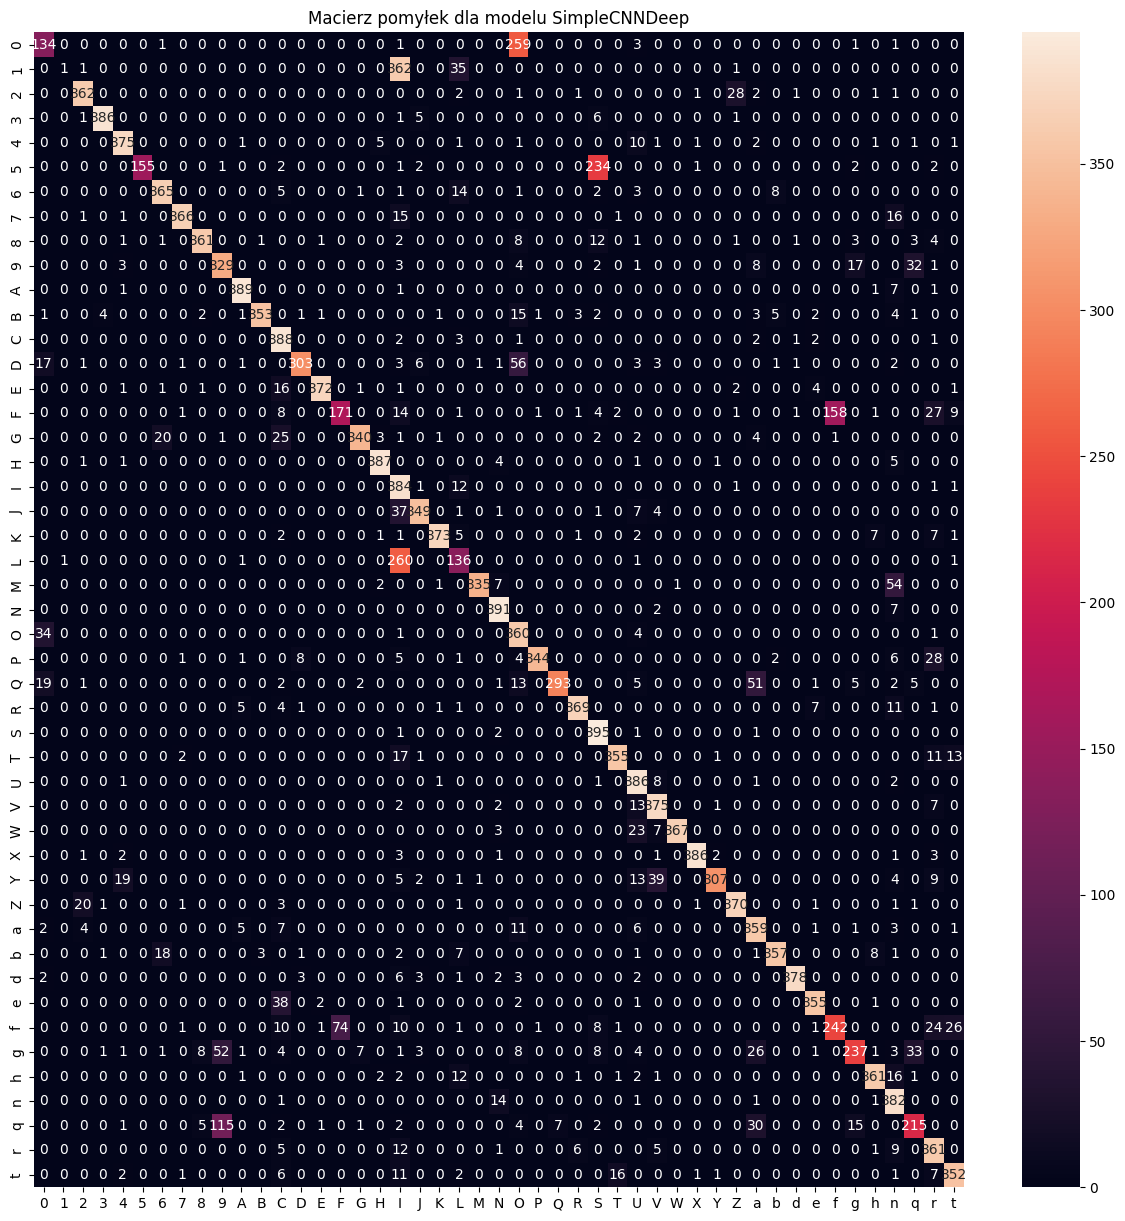

In [113]:
for model in models:
    ocen_model(model, test_dataloader, class_names, y_test)

### Wnioski z klasyfikacji

Najlepiej z powyższych poradziła sobie uproszczona architektura ResNet, osiągając najwyższą dokładność: prawie 89%. Dalej w kolejności od najlepszego: Prosta sieć konwolucyjna - szeroka, podstawowa i głęboka. Na macierzy pomyłek, że wszystkie modele myliły się najczęściej dla tych samych klas. Mała dokładność dla tych klas ma sens, ponieważ faktycznie są to zbliżone kształty, na przykład: (q i 9), (l i 1), (0 i O)... Niektóre z tych przykładów są trudne do odróżnienia nawet dla człowieka. Model głębszy szczególnie odstaje od reszty, najbardziej jest to widoczne na przekątnej dla klasy "1". Klasa ta była częściej mylona z literą "I" niż prawidłowo rozpoznawana.

#### Poniżej wyświetlamy predykcje modeli dla najgorzej rozpoznawanych przykładów.

Przykłady wybrane zostały na podstawie błędów najlepszego modelu - ResNet. Wtedy można porównać jak różne modele przewidują dla tych samych przykładów.

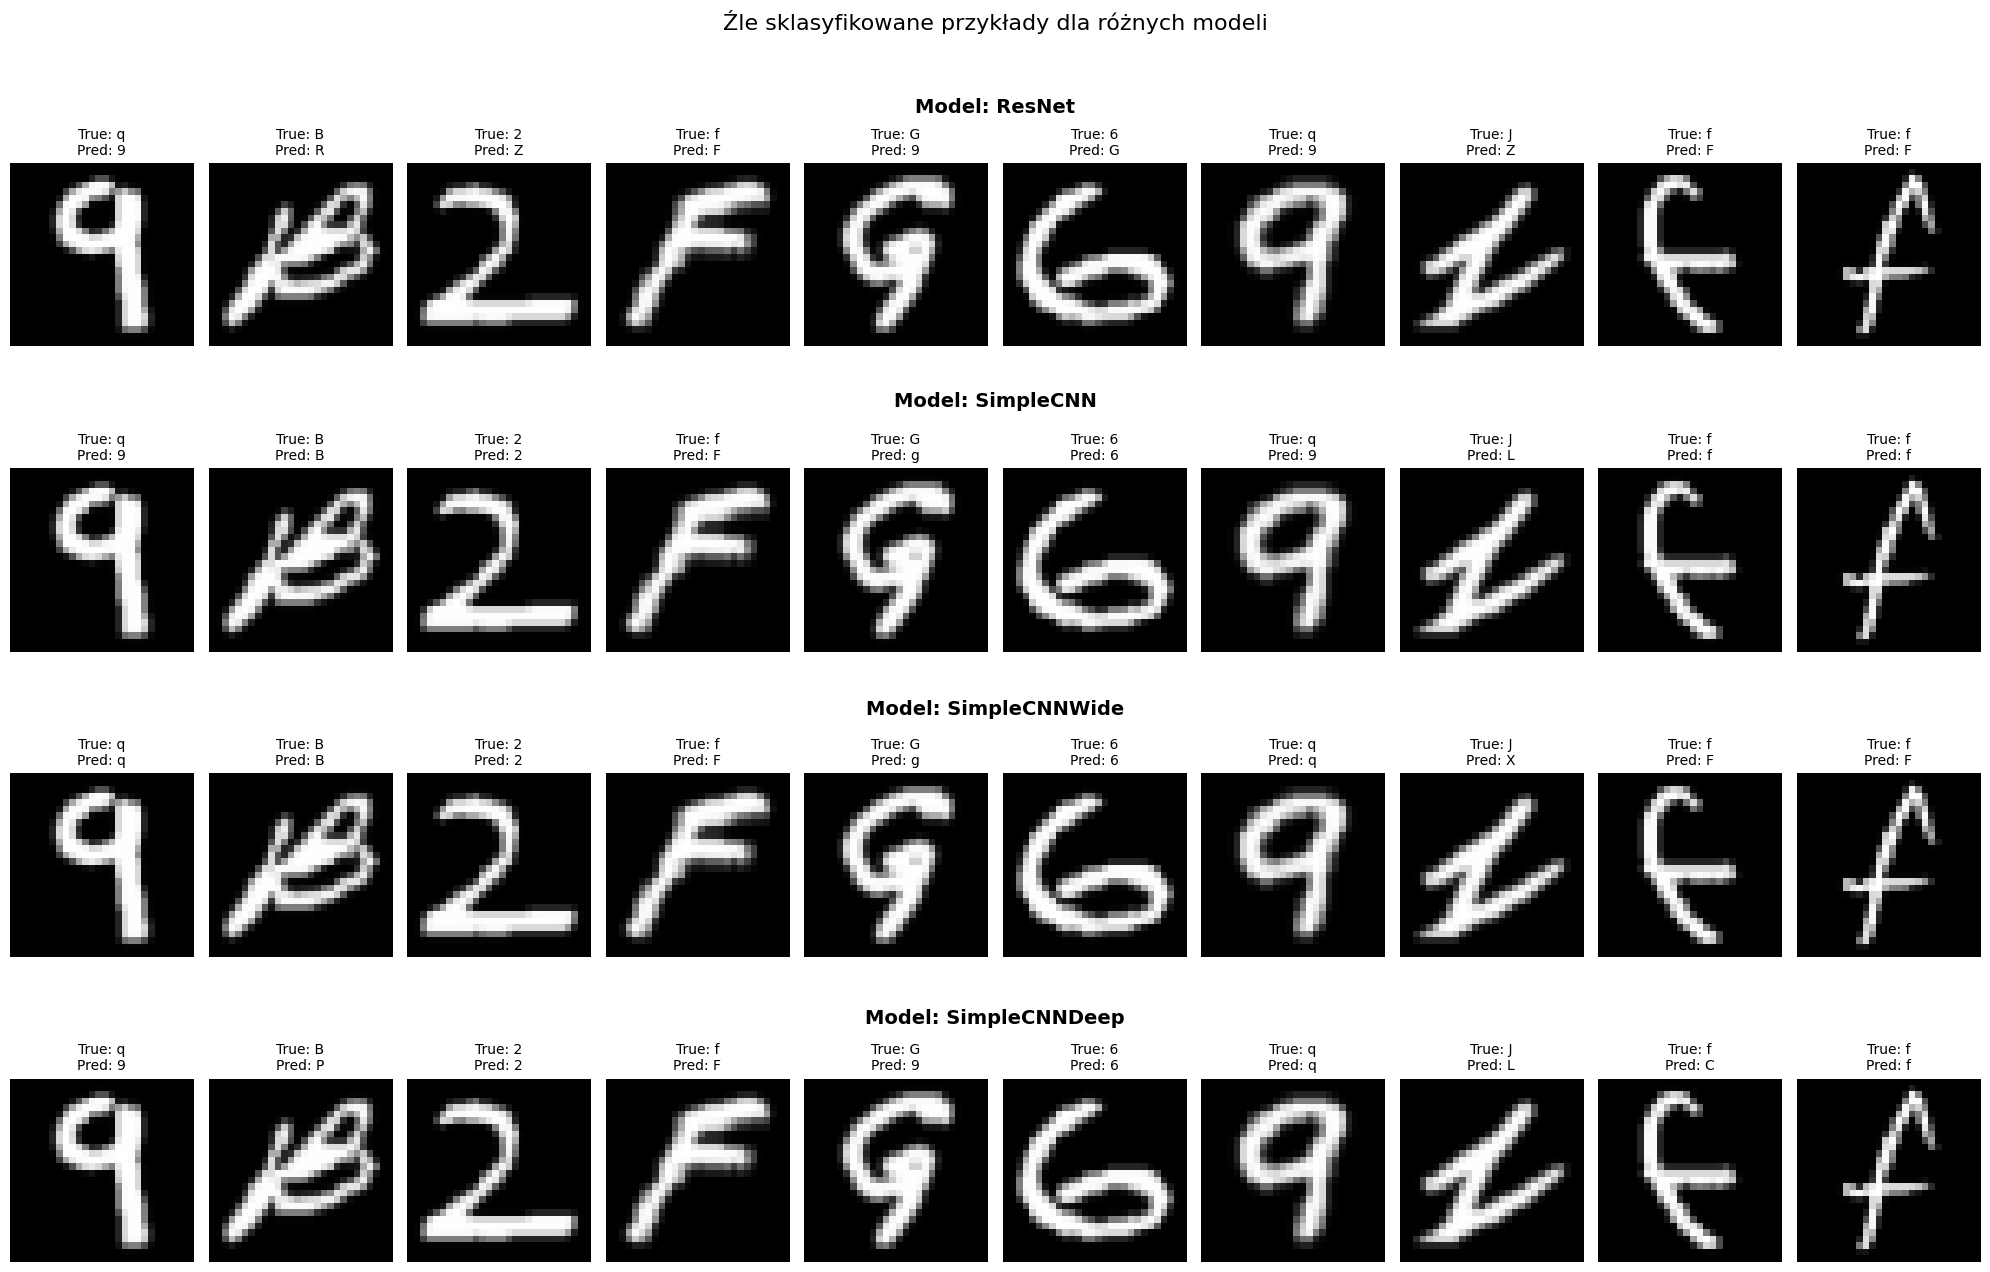

In [114]:
misclassified_indices = None  # Do przechowywania indeksów źle sklasyfikowanych przykładów

# Tworzenie figure dla 4 podwykresów (jeden dla każdego modelu)
fig, axes = plt.subplots(len(models), 10, figsize=(20, 14))  # Zwiększono wysokość wykresu
titles_loc = [0.88, 0.67, 0.45, 0.23]

for model_idx, model in enumerate(models):
    model.eval()

    # Weź batch danych z dataloadera
    inputs, labels = next(iter(test_dataloader))
    inputs, labels = inputs.to(device), labels.to(device)

    outputs = model(inputs)
    _, preds = torch.max(outputs, 1)

    # Wybierz błędne przykłady tylko dla pierwszego modelu
    if model_idx == 0:
        misclassified_indices = (preds != labels).nonzero(as_tuple=True)[0][:10]  # 10 przykładów

    # Użyj tych samych indeksów dla pozostałych modeli
    misclassified_inputs = inputs[misclassified_indices]
    misclassified_labels = labels[misclassified_indices]
    misclassified_preds = preds[misclassified_indices]

    # Wizualizuj błędnie sklasyfikowane obrazy
    num_images = len(misclassified_inputs)
    for i in range(num_images):
        ax = axes[model_idx, i]
        img = misclassified_inputs[i].cpu().numpy().squeeze()
        true_label = class_names[misclassified_labels[i].item()]
        pred_label = class_names[misclassified_preds[i].item()]

        ax.imshow(img, cmap='gray')
        ax.set_title(f'True: {true_label}\nPred: {pred_label}', fontsize=10)
        ax.axis('off')

    # Dodanie podtytułu nad wierszem
    fig.text(
        0.5, 
        titles_loc[model_idx], 
        f"Model: {model.__class__.__name__}", 
        ha='center', va='center', fontsize=14, fontweight='bold'
    )

# Dodanie przestrzeni między wierszami
plt.subplots_adjust(hspace=0.6)

# Ustawienie głównego tytułu
plt.suptitle("Źle sklasyfikowane przykłady dla różnych modeli", y=0.95, fontsize=16)
plt.tight_layout(rect=[0, 0, 1, 0.93])
plt.show()


#### Wnioski z analizy najgorzej rozpoznawanych przykładów

Na tym porównaniu widać, że nawet najlepszy model popełnia błędy. Błędy te natomiast nie nakładają się na siebie między modelami. Każdy z nich ma problemy z innymi kształtami. 
Najczęściej mylone są znaki, z którymi problem miałby nawet człowiek ze względu na wysokie podobieństwo, więc nie jest dużym zdziwieniem, że model nie zawsze jest w stanie je rozróżnić.
Często jakość tych pisanych ręcznie znaków jest niska lub są one napisane niedbale, co dodatkowo utrudnia zadanie modelom.

### Wnioski końcowe
Na podstawie przeprowadzonej analizy można sformułować następujące wnioski:

1. **Cel projektu:** Projekt miał na celu porównanie wariantów modeli klasycznych sieci splotowych pod kątem ich skuteczności w klasyfikacji znaków z bazy EMNIST.

2. **Zbiór danych:** Dane EMNIST Balanced zawierały 131600 przykładów (47 klas). Zbiór został podzielony na dane treningowe (86%) oraz testowe (14%). Dodatkowy podział na walidację umożliwił skuteczne monitorowanie wydajności modeli.

3. **Porównanie modeli:**
   - **ResNet**: Model ten osiągnął najwyższą dokładność oraz najlepszą generalizację na zbiorze testowym. Wykazał się stabilnością i skutecznością w odróżnianiu podobnych znaków, mimo że niektóre błędy wynikały z podobieństw wizualnych (np. "q" i "9").
   - **SimpleCNN**: Najprostszy model z grupy, charakteryzujący się niższą dokładnością. Był najbardziej podatny na błędy w rozróżnianiu znaków o złożonych kształtach.
   - **SimpleCNNWide**: Rozszerzona wersja modelu SimpleCNN pokazała poprawę dokładności, jednak wciąż była podatna na błędy związane z podobnymi kształtami znaków.
   - **SimpleCNNDeep**: Mimo głębszej architektury, model wykazał większe problemy z generalizacją, co może wynikać z przeuczenia. Wyniki były gorsze niż w przypadku ResNet.

4. **Trudności w klasyfikacji:** Wszystkie modele miały trudności z rozróżnianiem znaków o podobnych kształtach, takich jak "q" i "9" czy "G" i "6".

5. **Ogólne wnioski:**
   - ResNet okazał się najskuteczniejszym modelem z analizowanej grupy.
   - Proste modele CNN mogą być ulepszone poprzez zastosowanie metod regularyzacji (np. dropout) oraz odpowiedni tuning hiperparametrów.
   - Wybór architektury modelu powinien być dostosowany do złożoności problemu oraz dostępnych zasobów obliczeniowych.

Projekt potwierdził skuteczność bardziej zaawansowanych modeli, takich jak ResNet, w zadaniach klasyfikacyjnych na skomplikowanych zbiorach danych.